# Capstone Presentation

I will be investigating a Kaggle dataset gathered from a [Speed Dating Experiment](https://www.kaggle.com/annavictoria/speed-dating-experiment). It was compiled by 2 Columbia Business School professors for their paper "Gender Differences in Mate Selection: Evidence From a Speed Dating Experiment", which they wrote in an effort to understand what influences "love at first sight".

Data was gathered from participants in experimental speed dating events 2002 - 2004. During the events, the attendees had a 4-minute "first date" with every other participant of the opposite sex. At the end of their 4 minutes, participants rated their date on 6 attributes: 

- Attractiveness
- Sincerity
- Intelligence
- Fun
- Ambition
- Shared Interests

The dataset also includes questionnaire data gathered from participants at different points in the process (i.e. demographics, dating habits, self-perception across key attributes, beliefs on what others find valuable in a mate, and lifestyle information). 

My goal is to be able to take this questionnaire data (namely each person's preferences, ratings, thoughts on the opposite sex's preferences, thoughts on how he/she measures up to opposite sex's preferences, etc.) to predict whether 2 people will be a match.

## Explore & Clean Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import ensemble
from sklearn.svm import SVC
from collections import Counter
from itertools import compress
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.decomposition import PCA

raw_data = pd.read_csv('./data/speed_dating.csv', encoding="ISO-8859-1")
print(list(raw_data.columns))
print(raw_data.shape[0], 'Rows')
print(raw_data.shape[1], 'Columns')
raw_data.head()

['iid', 'id', 'gender', 'idg', 'condtn', 'wave', 'round', 'position', 'positin1', 'order', 'partner', 'pid', 'match', 'int_corr', 'samerace', 'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o', 'age', 'field', 'field_cd', 'undergra', 'mn_sat', 'tuition', 'race', 'imprace', 'imprelig', 'from', 'zipcode', 'income', 'goal', 'date', 'go_out', 'career', 'career_c', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'exphappy', 'expnum', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1', 'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1', 'de

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [2]:
# PRELIMINARY
my_prefs = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
guess_opp_sex_prefs = ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
guess_my_rating_by_opp_sex = ['attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1']
guess_my_sex_prefs = ['attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1']
guess_my_perception = ['attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1']
partners_prefs = ['pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha']
all_prelim = my_prefs + guess_opp_sex_prefs + guess_my_rating_by_opp_sex + guess_my_sex_prefs + guess_my_perception + partners_prefs 

# HALFWAY THROUGH DATES
my_prefs_half = ['attr1_s', 'sinc1_s', 'intel1_s', 'fun1_s', 'amb1_s', 'shar1_s']
my_rate_self_half = ['attr3_s', 'sinc3_s', 'intel3_s', 'fun3_s', 'amb3_s']
all_half = my_prefs_half + my_rate_self_half

# AFTER DATES
my_prefs_all = ['attr1_2', 'sinc1_2', 'intel1_2', 'fun1_2', 'amb1_2', 'shar1_2']
guess_opp_sex_prefs_all = ['attr2_2', 'sinc2_2', 'intel2_2', 'fun2_2', 'amb2_2', 'shar2_2']
guess_my_rating_by_opp_sex_all = ['attr3_2', 'sinc3_2', 'intel3_2', 'fun3_2', 'amb3_2']
guess_my_sex_prefs_all = ['attr4_2', 'sinc4_2', 'intel4_2', 'fun4_2', 'amb4_2', 'shar4_2']
guess_my_perception_all = ['attr5_2', 'sinc5_2', 'intel5_2', 'fun5_2', 'amb5_2']
my_actual_prefs_all = ['attr7_2', 'sinc7_2', 'intel7_2', 'fun7_2', 'amb7_2', 'shar7_2']
all_after = my_prefs_all + guess_opp_sex_prefs_all + guess_my_rating_by_opp_sex_all + guess_my_sex_prefs_all + guess_my_perception_all + my_actual_prefs_all

# DECISIONS
ratings_for_me = ['attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o']
ratings_for_partner = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob']
all_decs = ratings_for_me + ratings_for_partner

# WEEKS AFTER SENT MATCHES
all_followup = []

cols_to_scale = all_prelim + all_half + all_after + all_decs + all_followup
cols_always_10_scale = ['imprace', 'imprelig', 'exphappy', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'satis_2']

In [3]:
# TODO: faster way to run this code?
def first_pass_clean(row):
    meas_max = get_pref_measurement(row['wave'])
    return get_scaled_row(row, meas_max)

def get_pref_measurement(wave):
    return 10 if wave in [6, 7, 8, 9] else 100

def get_scaled_row(row, meas_max):
    for col in cols_to_scale:
        row[col] = row[col] / meas_max
        
    for col in cols_always_10_scale:
        row[col] = row[col] / 10
    return row

raw_data = raw_data.apply(first_pass_clean, axis=1)
raw_data.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


4099 missing vals for income
Avg: 44887.61


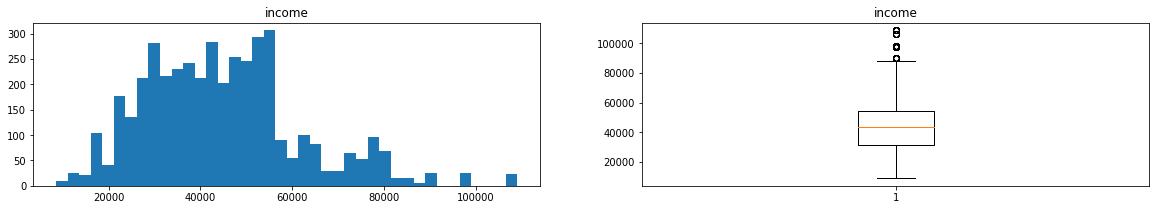

4795 missing vals for tuition
Avg: 21174.93


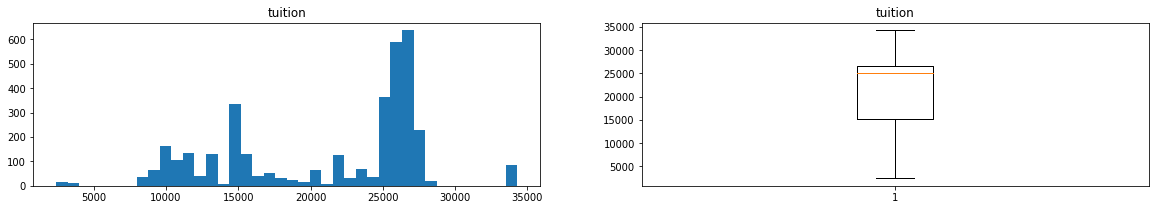

5245 missing vals for mn_sat
Avg: 1299.66


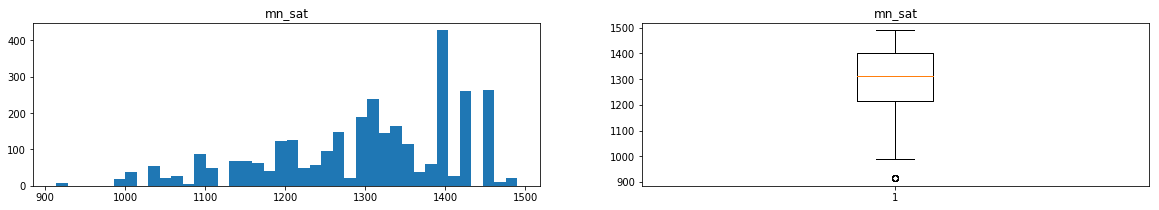

158 missing vals for int_corr
Avg: 0.2


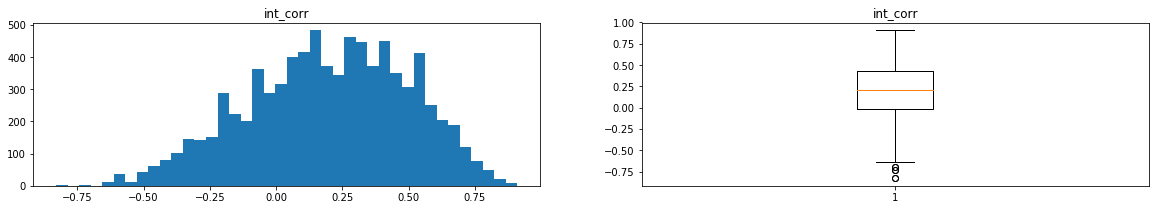

104 missing vals for age_o
Avg: 26.36


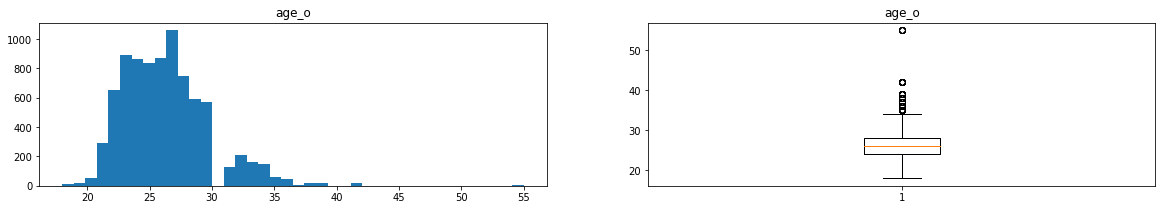

1076 missing vals for shar_o
Avg: 0.15


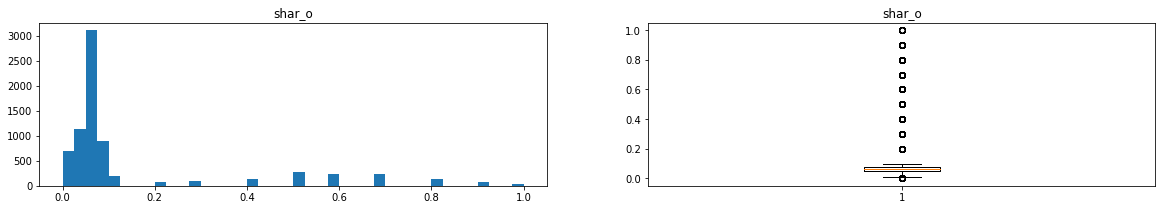

1067 missing vals for shar
Avg: 0.15


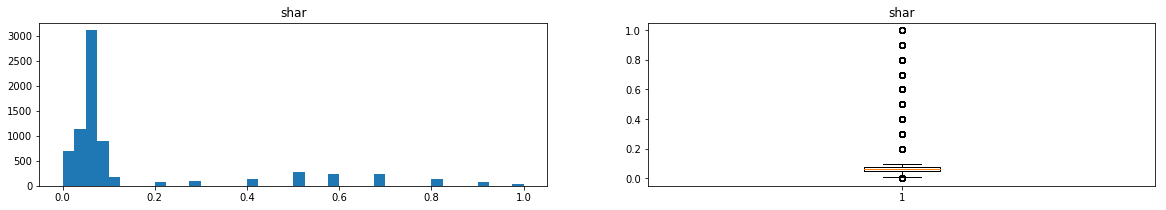

In [4]:
# IMPUTATIONS – income, tuition, mn_sat
def visualize_to_impute(df, cols):
    for col in cols:
        print(df[col].isnull().sum(), 'missing vals for', col)
        df[col] = df[col].apply(lambda x: float(str(x).replace(',','')) if x is not None else 0)

        median_val = df[col].dropna().median()
        print('Avg:', round(mean_val, 2))

        plt.figure(figsize=(20,3))

        plt.subplot(1, 2, 1)
        plt.hist(df[col].dropna(), bins=40)
        plt.title(col)

        plt.subplot(1, 2, 2)
        plt.boxplot(df[col].dropna())
        plt.title(col)

        plt.show()

        df[col] = df[col].apply(lambda x: x if x > 0 else median_val)
    return df

raw_data = visualize_to_impute(raw_data, ['income', 'tuition', 'mn_sat', 'int_corr', 'age_o', 'shar_o', 'shar'])

In [5]:
# cols_to_create = ['age_diff_norm', 'same_field_cd', 'same_goal', 'same_income', 'same_tuition']
# cols_to_clean_impute = ['undergra', 'from', 'mn_sat', 'zipcode']

# Clean zip code
raw_data['zipcode'] = raw_data['zipcode'].apply(lambda x: float(str(x).replace(',','')) if x is not None else None)
raw_data = raw_data[raw_data['zipcode'] <= 99950]
raw_data = raw_data[raw_data['zipcode'] >= 501]
raw_data['zipcode'] = raw_data['zipcode'].apply(lambda x: str(x).zfill(5))

In [6]:
# # Drop rows with incorrect math
# df['my_prefs_total'] = df[my_prefs].sum(axis='columns')
# df['partners_prefs_total'] = df[partners_prefs].sum(axis='columns')
# df['guess_opp_sex_prefs_total'] = df[guess_opp_sex_prefs].sum(axis='columns')

# total_col_names = ['my_prefs_total', 'partners_prefs_total', 'guess_opp_sex_prefs_total']
# for col in total_col_names:
#     print(col, '\n* uniq vals –', ', '.join(map(lambda x: str(round(x, 2)), list(df[col].unique()))))

#     # Drop row if math is off by more than 10% (0.1)
#     old_num = df.shape[0]
#     df = df[df[col] <= 1.1]
#     df = df[df[col] >= 0.9]
#     num_dropped = old_num - df.shape[0]
#     perc_dropped = round(num_dropped / old_num * 100, 2)
#     print('* {} rows dropped ({}%) \n* {} rows left\n'.format(num_dropped, perc_dropped, df.shape[0]))

# df = df.drop(columns=total_col_names)
# df.head()

## Feature Engineering

In [7]:
def get_region(from_input):
    for east_region in ['working', 'New York', 'New Jersey', 'New York City', 'Queens', 'J.P. Morgan', 'Vestal', 'Vermont', 'Manhattan', 'Staten', 'Bronx', 'Brandeis', 'Bowdoin', 'Brooklyn', 'Baltimore', 'Boston', 'Maryland', 'Pittsburgh', 'Massachusetts', 'Connecticut', 'Virginia', 'Washington, ', 'Pennsylvania', 'N.Y.', 'Philadelphia', 'NYC', 'Long Island']:
        if east_region.lower() in from_input.lower():
            return 'USA - East'
    for east_abbrev in ['DC', 'MA', 'PA', 'NJ', 'NY', 'MD', 'CT']:
        if east_abbrev in from_input:
            return 'USA - East'
        
    for west_region in ['California', 'San Francisco', 'Los Angeles', '94115', 'Seattle', 'Arizona', 'Salt Lake City', 'San Diego', 'Colorado', 'Hawaii', 'Berkeley', 'Washington State', 'Nevada', 'Oregon', 'New Mexico']:
        if west_region.lower() in from_input.lower():
            return 'USA - West'
    for west_abbrev in ['CA', 'NM']:
        if west_abbrev in from_input:
            return 'USA - West'
        
    for south_region in ['Alabama', 'Texas', 'Georgia', 'Miami', 'Atlanta', 'Florida', 'Carolina', 'Houston', 'Louisiana']:
        if south_region.lower() in from_input.lower():
            return 'USA - South'
    for south_abbrev in ['TN', 'GA', 'TX']:
        if south_abbrev in from_input:
            return 'USA - South'
        
    for midw_region in ['Midwest USA', 'Chicago', 'Minnesota', 'Michigan', 'Missouri', 'Ohio', 'Wisconsin', 'Ann Arbor', 'Minneapolis', 'Detroit', 'Cleveland', 'Nebraska', 'Iowa', 'Kansas']:
        if midw_region.lower() in from_input.lower():
            return 'USA - MidWest'
    for midw_abbrev in ['MI', 'MO', 'OH', 'MN']:
        if midw_abbrev in from_input:
            return 'USA - MidWest'
        
    for eur_region in ['Italy', 'France', 'Germany', 'England', 'Belgium', 'Greece', 'Spain', 'Budapest', 'Sweden', 'Switzerland', 'Paris', 'Albania']:
        if eur_region.lower() in from_input.lower():
            return 'Europe'
        
    for asia_region in ['China', 'Taiwan', 'Philippines', 'Israel', 'Japan', 'Indonesia', 'India', 'Singapore', 'Iran', 'Nepal', 'Russia', 'Hong Kong']:
        if asia_region.lower() in from_input.lower():
            return 'Asia'
        
    for samerica_region in ['South America', 'Brazil', 'Argentina', 'Uruguay', 'Venezuela', 'Panama', 'Puerto Rico']:
        if samerica_region.lower() in from_input.lower():
            return 'Central / S. America / S. Pacific'
    
    if from_input.lower() == 'australia':
        return 'Australia'
    
    if from_input.lower() in ['mexico', 'canada']:
        return 'N. America'

    else:
        return from_input

raw_data['from'] = raw_data['from'].apply(get_region)
raw_data['from'].value_counts()

USA - East                           3128
USA - West                           1141
USA - MidWest                         576
USA - South                           516
Europe                                507
Asia                                  473
Central / S. America / S. Pacific      96
N. America                             53
International Student                  21
Australia                              20
Name: from, dtype: int64

In [8]:
def first_pass_feat_engineer(row):
    row['male_older'] = is_male_older(row)
    row['same_field_cd'] = is_col_same(row, 'field_cd')
    row['same_career_c'] = is_col_same(row, 'career_c')
    row['match_es_perc'] = row['match_es'] / row['round']
    row['age_diff'] = row['age'] - row['age_o']
    row['same_from'] = is_col_same(row, 'from')
    
    return row

def is_male_older(row):
    return 1 if (row['age'] - row['age_o'] > 0) and (row['gender'] == 1) else 0

def is_col_same(row, col):
    partners_rows = raw_data[raw_data['iid'] == row['pid']]
    if len(partners_rows) > 0:
        partners_row = partners_rows.iloc[0,:]
        return 1 if row[col] == partners_row[col] else 0
    else:
        return float('NaN')

raw_data = raw_data.apply(first_pass_feat_engineer, axis=1)
raw_data.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,sinc5_3,intel5_3,fun5_3,amb5_3,male_older,same_field_cd,same_career_c,match_es_perc,age_diff,same_from
0,1,1.0,0,1,1,1,10,7,NaN,4,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0.4,-6.0,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,NaN,NaN,NaN,NaN,0,1.0,0.0,0.4,-1.0,0.0
2,1,1.0,0,1,1,1,10,7,NaN,10,...,NaN,NaN,NaN,NaN,0,1.0,0.0,0.4,-1.0,0.0
3,1,1.0,0,1,1,1,10,7,NaN,5,...,NaN,NaN,NaN,NaN,0,1.0,0.0,0.4,-2.0,1.0
4,1,1.0,0,1,1,1,10,7,NaN,7,...,NaN,NaN,NaN,NaN,0,1.0,0.0,0.4,-3.0,0.0


## Prep Data for Modeling

In [9]:
cols_to_dummify = ['gender', 'condtn', 'samerace', 'from']
cols_to_minscale = ['income', 'tuition', 'mn_sat', 'age_diff']

def dummify_cols(df, cols):
    for col in cols:
        num_nulls = df[col].isnull().sum()

        if num_nulls > 0:
            val_counts = df[col].value_counts()
            most_common_val = val_counts.index[0]
            df[col] = df[col].fillna(value=most_common_val)
            
        df = pd.concat([df.drop(columns=[col], axis=1), pd.get_dummies(df[col], prefix=col)], axis=1)
    return df

def minscale_cols(df, cols):
    for col in cols:
        df[col] = (df[col] - df[col].mean()) / df[col].max()
    return df

raw_data = dummify_cols(raw_data, cols_to_dummify)
raw_data = minscale_cols(raw_data, cols_to_minscale)

In [10]:
diff_my_prefs_and_ratings = []
diff_partners_prefs_and_ratings = []

def get_diff_cols(df):
    for idx in range(len(my_prefs)):
        diff_col = 'diff_my_' + ratings_for_partner[idx]
        diff_my_prefs_and_ratings.append(diff_col)
        df[diff_col] = df[my_prefs[idx]] - df[ratings_for_partner[idx]]

    for idx in range(len(partners_prefs)):
        diff_col = 'diff_partners_' + ratings_for_me[idx]
        diff_partners_prefs_and_ratings.append(diff_col)
        df[diff_col] = df[partners_prefs[idx]] - df[ratings_for_me[idx]]
    
    return df

raw_data = get_diff_cols(raw_data)

In [11]:
def get_cols_many_nans(df):
    cols_many_nans = []
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            num_nans = df[col].isnull().sum()
            percent_nans = round(num_nans / df.shape[0] * 100, 2)
            if percent_nans > 40:
                cols_many_nans.append(col)
    return cols_many_nans

cols_many_nans = get_cols_many_nans(raw_data)
id_cleaned_cols = ['id', 'partner', 'pid', 'idg', 'wave', 'position', 'positin1', 'order', 'field', 'undergra', 'career', 'match_es', 'round', 'age', 'age_o']
throwaway_cols = ['dec', 'dec_o', 'field_cd', 'goal', 'met', 'met_o', 'go_out', 'numdat_2', 'career_c', 'length', 'date', 'race', 'race_o', 'same_from']

# Drop 1) cols with more than 30% NaNs
# 2) cols with ids and 
# 3) cols with already-imputed / cleaned / dummified cols
# 4) throwaway cols
print('Dropped cols with 40%+ NaNs:', cols_many_nans)
raw_data.drop(labels=(cols_many_nans + id_cleaned_cols + throwaway_cols), axis=1, inplace=True)

print(raw_data.shape)
raw_data.head()

Dropped cols with 40%+ NaNs: ['undergra', 'expnum', 'attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1', 'attr1_s', 'sinc1_s', 'intel1_s', 'fun1_s', 'amb1_s', 'shar1_s', 'attr3_s', 'sinc3_s', 'intel3_s', 'fun3_s', 'amb3_s', 'attr7_2', 'sinc7_2', 'intel7_2', 'fun7_2', 'amb7_2', 'shar7_2', 'attr5_2', 'sinc5_2', 'intel5_2', 'fun5_2', 'amb5_2', 'you_call', 'them_cal', 'date_3', 'numdat_3', 'num_in_3', 'attr1_3', 'sinc1_3', 'intel1_3', 'fun1_3', 'amb1_3', 'shar1_3', 'attr7_3', 'sinc7_3', 'intel7_3', 'fun7_3', 'amb7_3', 'shar7_3', 'attr4_3', 'sinc4_3', 'intel4_3', 'fun4_3', 'amb4_3', 'shar4_3', 'attr2_3', 'sinc2_3', 'intel2_3', 'fun2_3', 'amb2_3', 'shar2_3', 'attr3_3', 'sinc3_3', 'intel3_3', 'fun3_3', 'amb3_3', 'attr5_3', 'sinc5_3', 'intel5_3', 'fun5_3', 'amb5_3']
(6531, 129)


,iid,match,int_corr,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,attr_o,...,diff_my_intel,diff_my_fun,diff_my_amb,diff_my_shar,diff_partners_attr_o,diff_partners_sinc_o,diff_partners_intel_o,diff_partners_fun_o,diff_partners_amb_o,diff_partners_shar_o
0,1,0,0.14,0.35,0.20,0.20,0.20,0.00,0.05,0.06,...,0.13,0.08,0.09,0.10,0.29,0.12,0.12,0.12,-0.08,-0.01
1,1,0,0.54,0.60,0.00,0.00,0.40,0.00,0.00,0.07,...,0.13,0.07,0.10,0.09,0.53,-0.08,-0.10,0.33,-0.07,-0.05
2,1,1,0.16,0.19,0.18,0.19,0.18,0.14,0.12,0.10,...,0.11,0.07,0.10,0.08,0.09,0.08,0.09,0.08,0.04,0.02
3,1,1,0.61,0.30,0.05,0.15,0.40,0.05,0.05,0.07,...,0.12,0.08,0.09,0.07,0.23,-0.03,0.06,0.32,-0.04,-0.03
4,1,1,0.21,0.30,0.10,0.20,0.10,0.10,0.20,0.08,...,0.13,0.08,0.09,0.09,0.22,0.03,0.11,0.04,0.01,0.13


0 missing vals for int_corr
Avg: 0.3


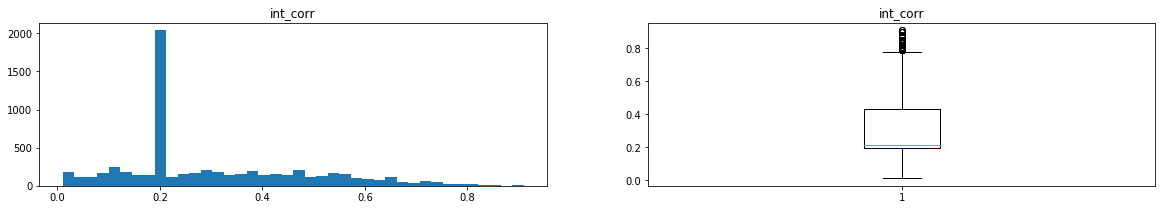

58 missing vals for pf_o_att
Avg: 0.5


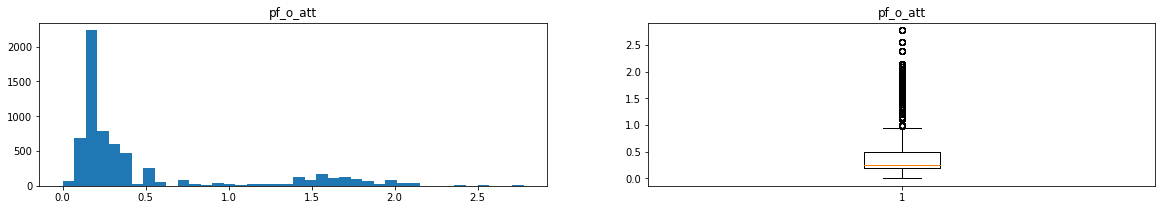

58 missing vals for pf_o_sin
Avg: 0.47


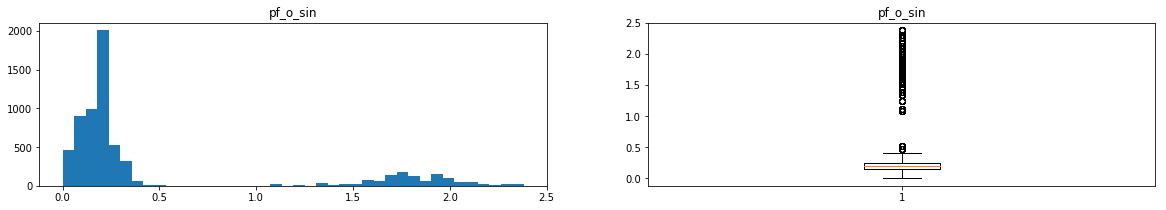

58 missing vals for pf_o_int
Avg: 0.52


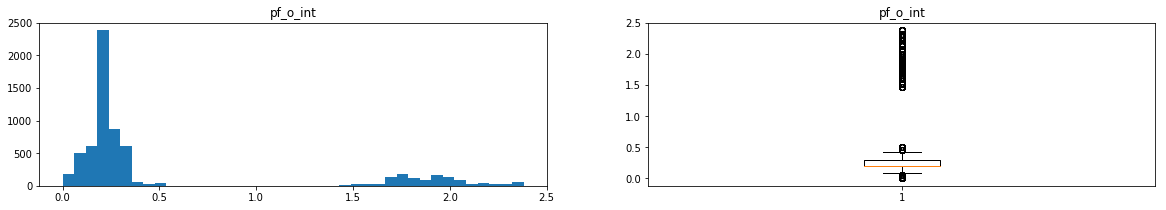

66 missing vals for pf_o_fun
Avg: 0.48


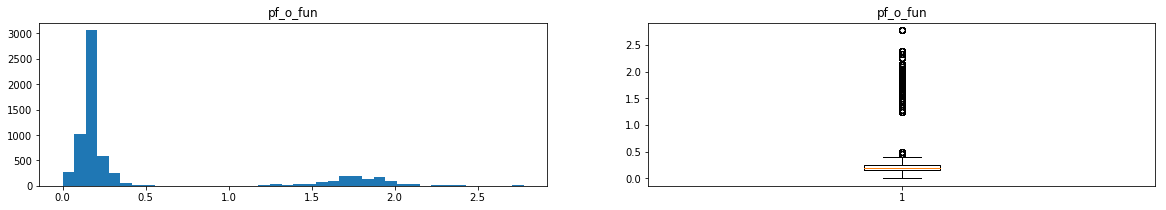

74 missing vals for pf_o_amb
Avg: 0.35


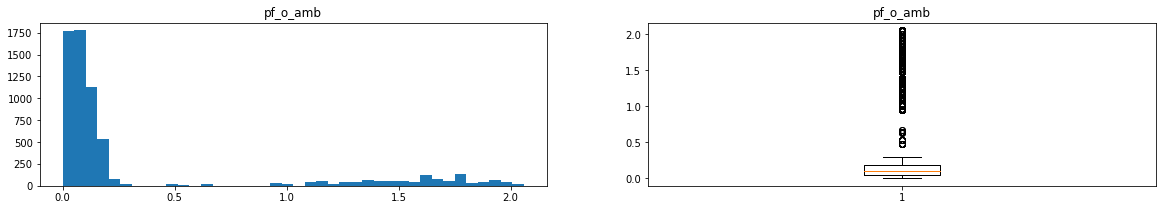

91 missing vals for pf_o_sha
Avg: 0.36


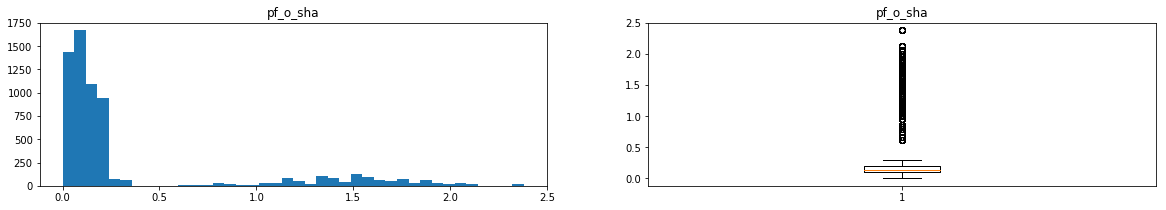

173 missing vals for attr_o
Avg: 0.17


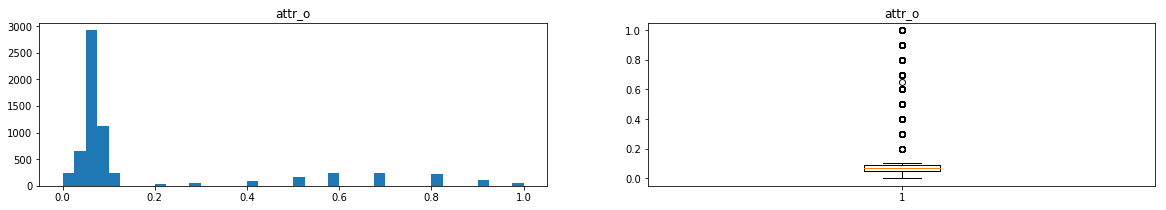

224 missing vals for sinc_o
Avg: 0.2


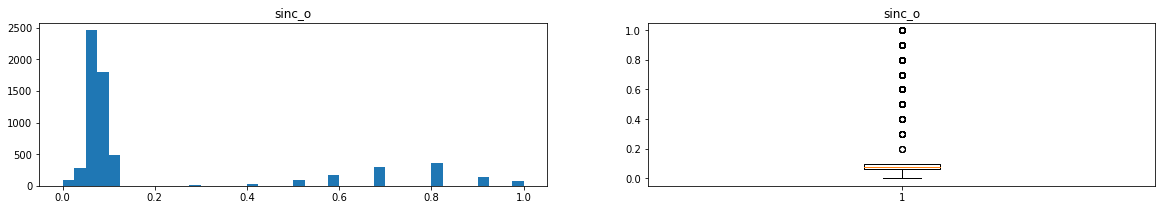

243 missing vals for intel_o
Avg: 0.2


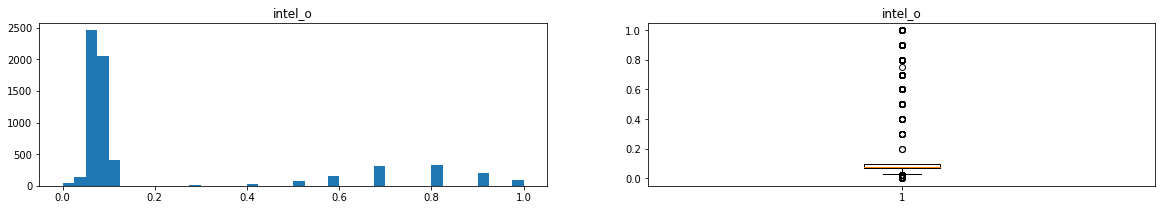

290 missing vals for fun_o
Avg: 0.18


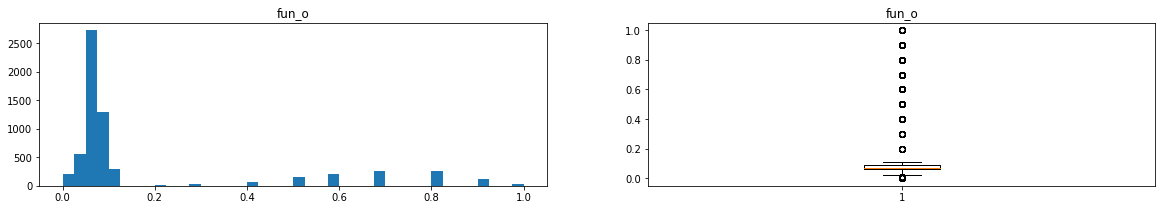

565 missing vals for amb_o
Avg: 0.19


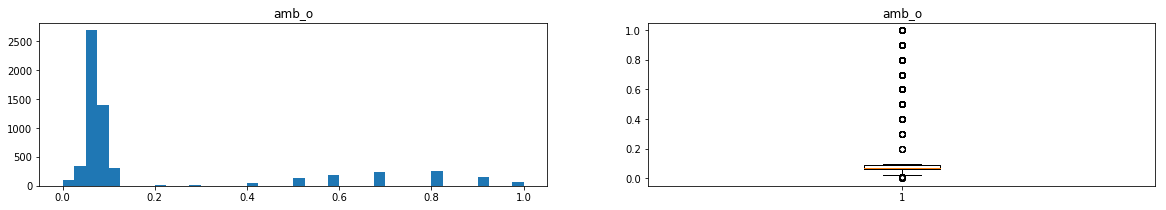

0 missing vals for shar_o
Avg: 0.15


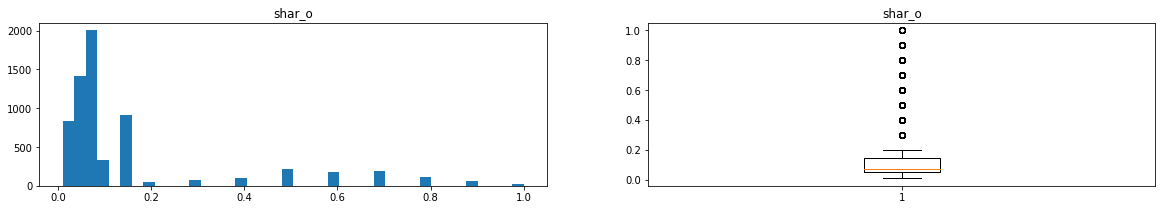

202 missing vals for like_o
Avg: 0.17


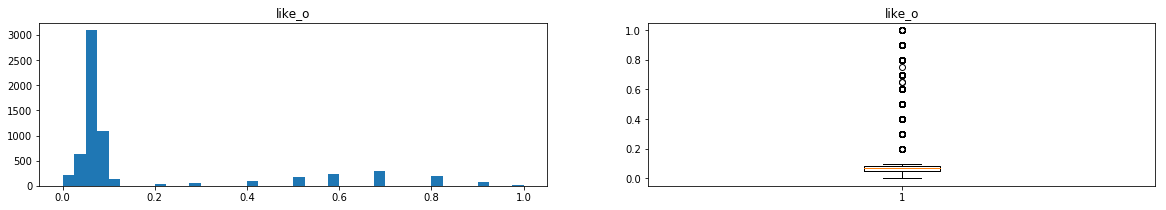

255 missing vals for prob_o
Avg: 0.15


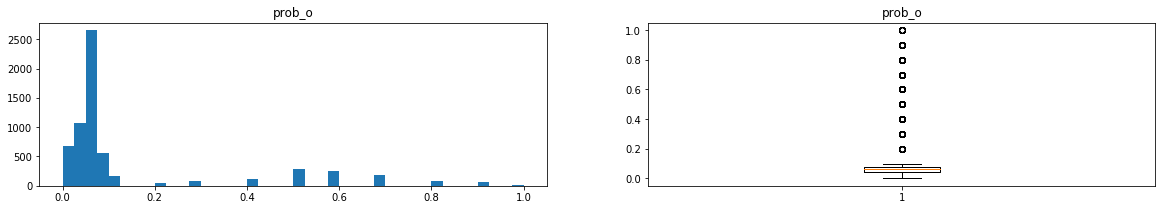

0 missing vals for mn_sat
Avg: -0.0


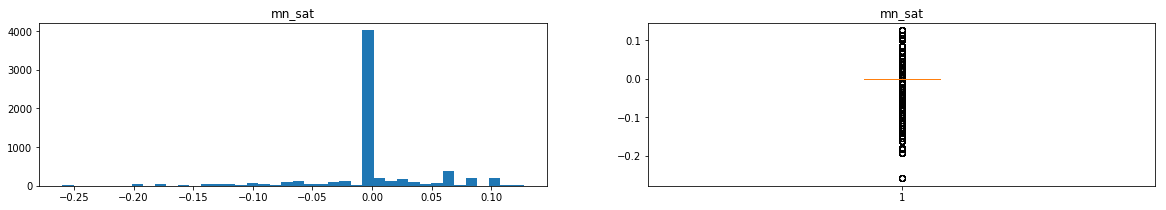

0 missing vals for tuition
Avg: -0.0


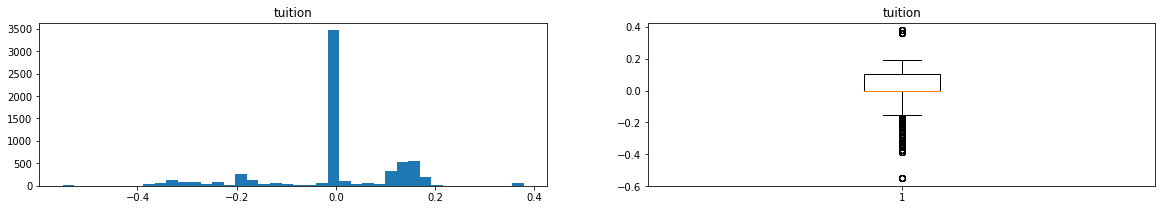

0 missing vals for imprace
Avg: 0.4


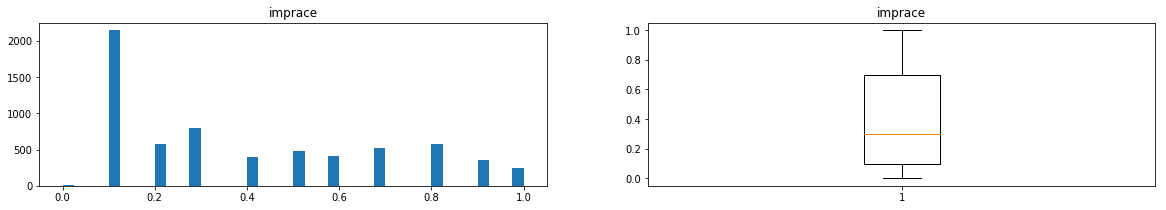

0 missing vals for imprelig
Avg: 0.38


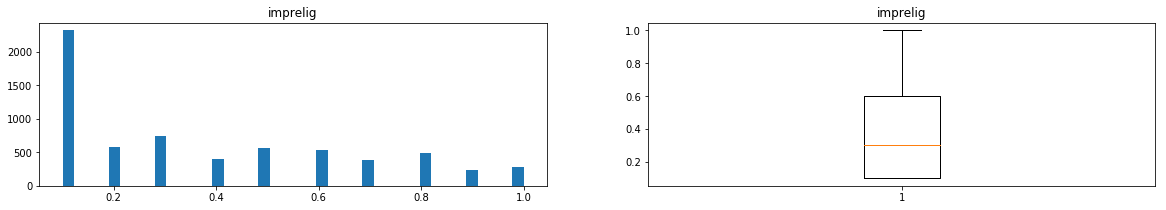

0 missing vals for income
Avg: -0.0


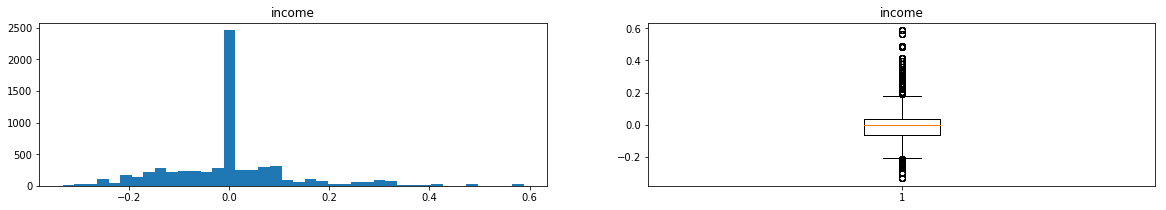

0 missing vals for sports
Avg: 0.64


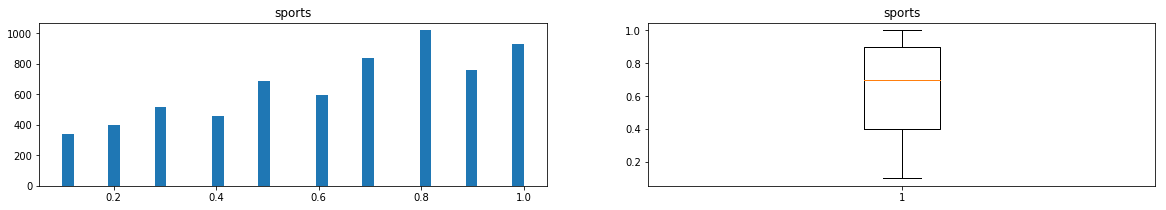

0 missing vals for tvsports
Avg: 0.46


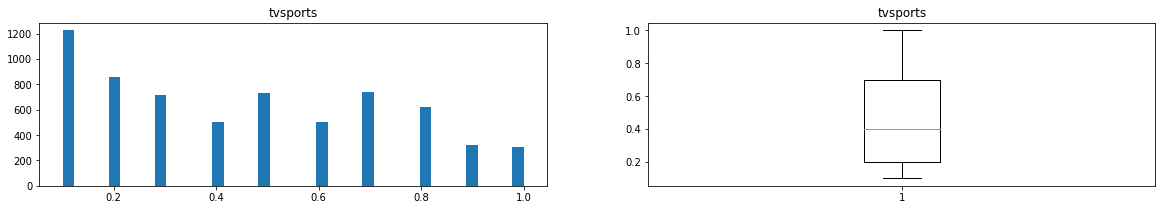

0 missing vals for exercise
Avg: 0.64


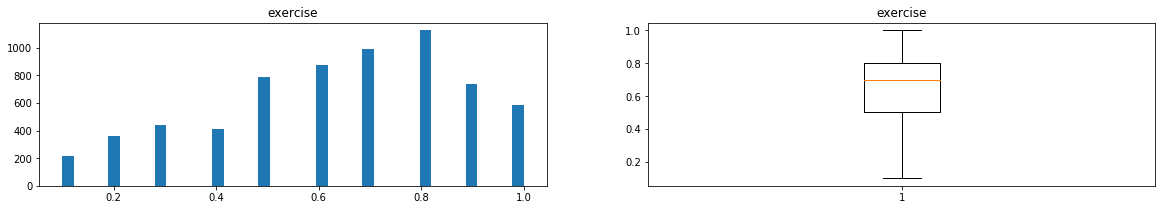

0 missing vals for dining
Avg: 0.78


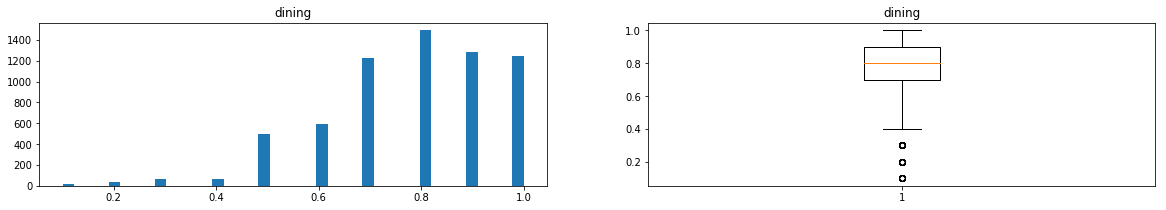

0 missing vals for museums
Avg: 0.7


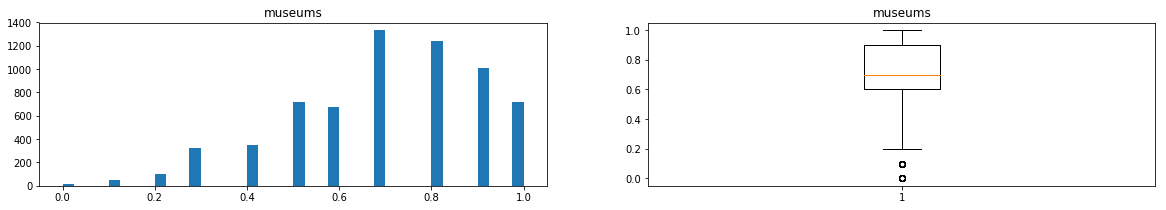

0 missing vals for art
Avg: 0.67


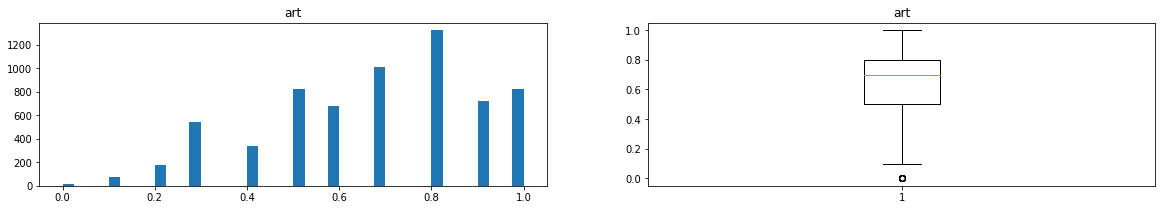

0 missing vals for hiking
Avg: 0.57


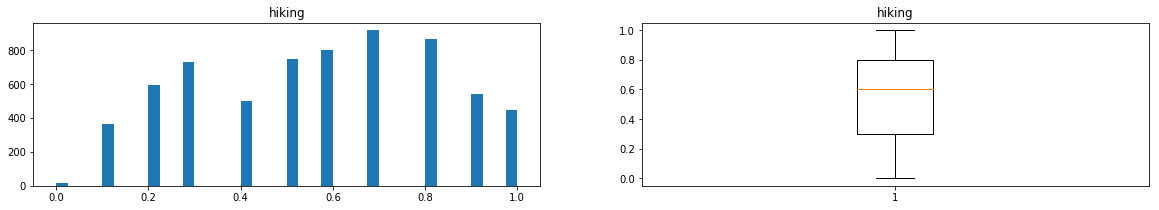

0 missing vals for gaming
Avg: 0.38


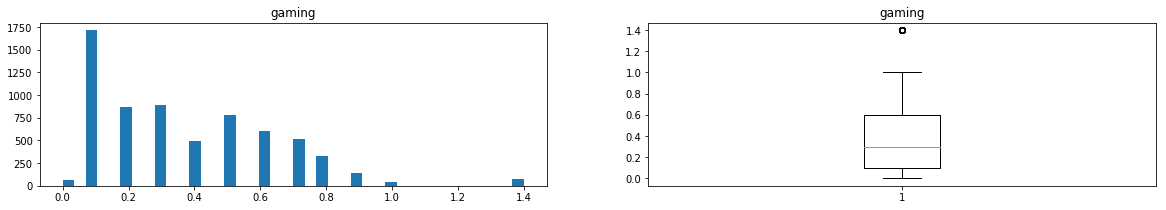

0 missing vals for clubbing
Avg: 0.57


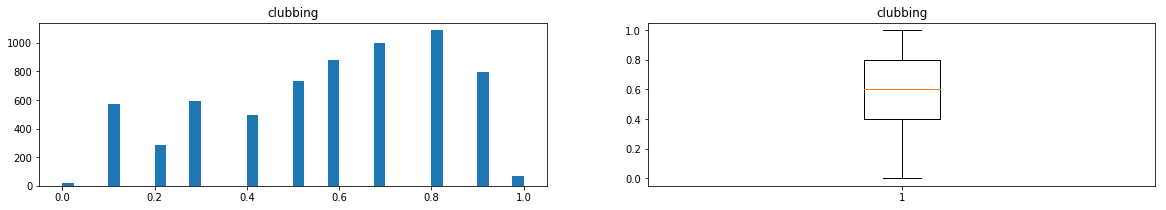

0 missing vals for reading
Avg: 0.77


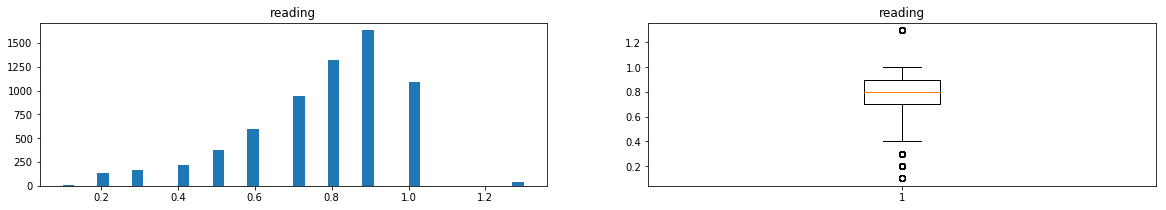

0 missing vals for tv
Avg: 0.54


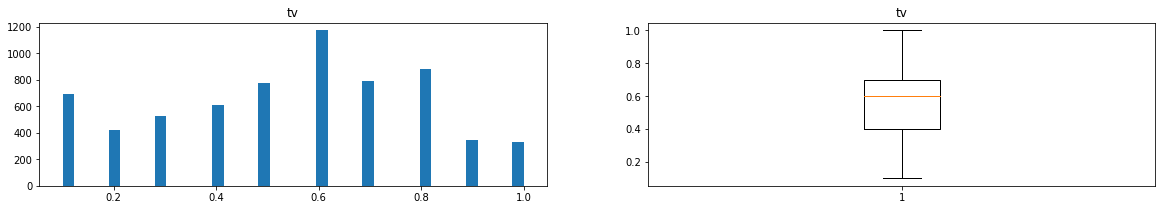

0 missing vals for theater
Avg: 0.68


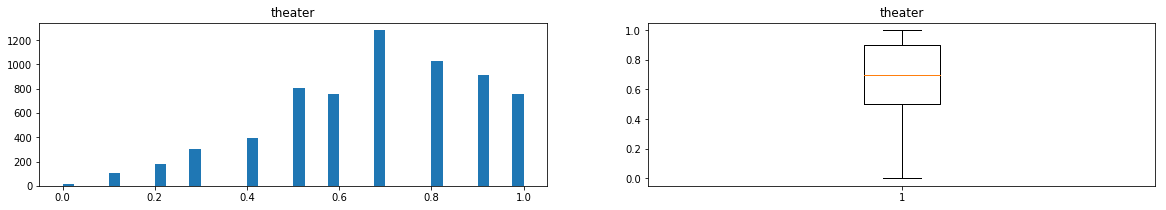

0 missing vals for movies
Avg: 0.79


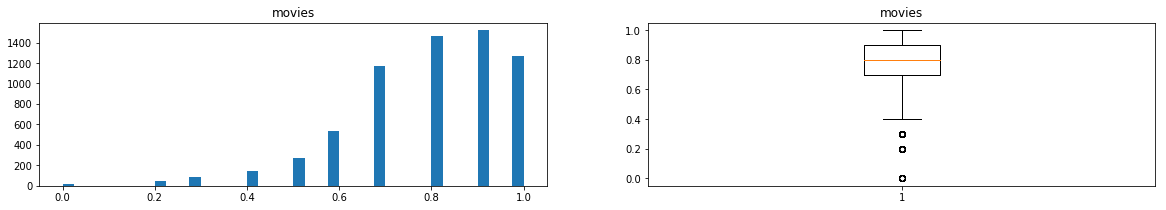

0 missing vals for concerts
Avg: 0.68


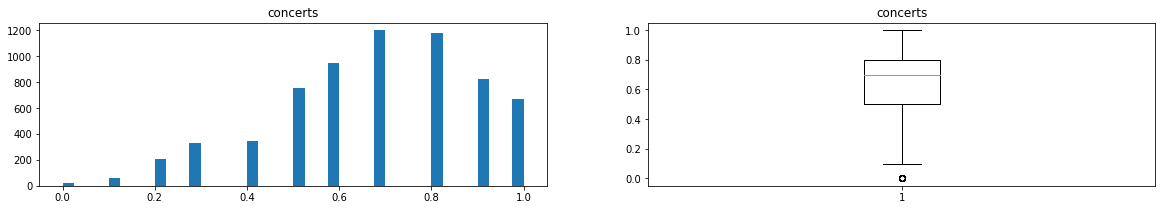

0 missing vals for music
Avg: 0.79


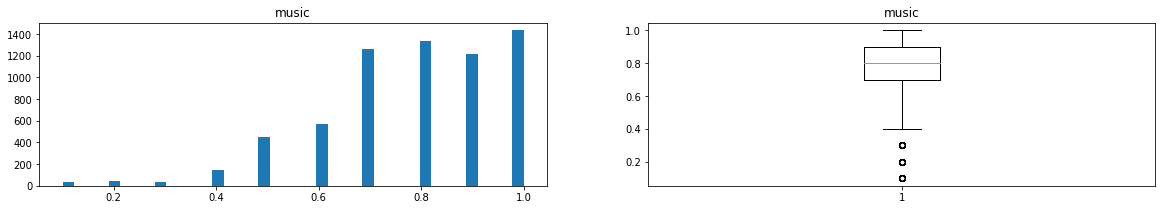

0 missing vals for shopping
Avg: 0.57


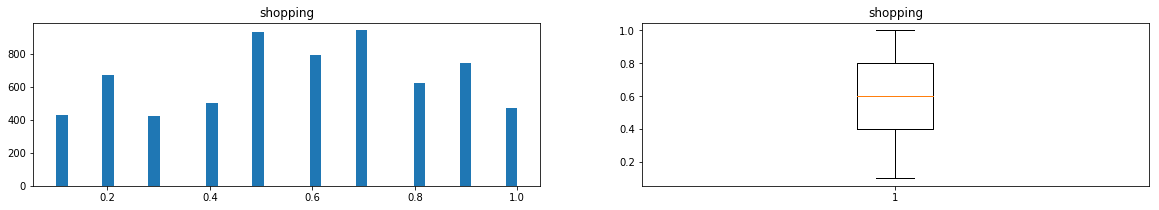

0 missing vals for yoga
Avg: 0.43


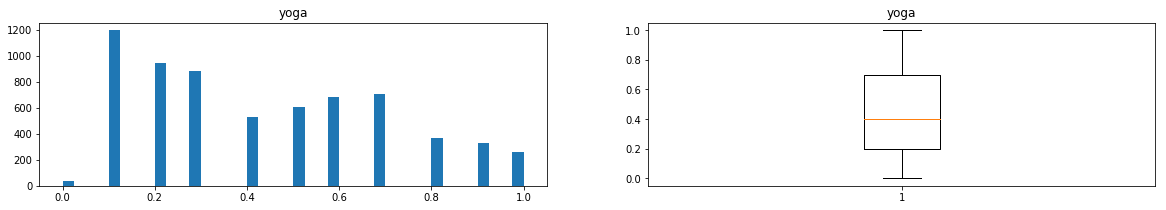

22 missing vals for exphappy
Avg: 0.55


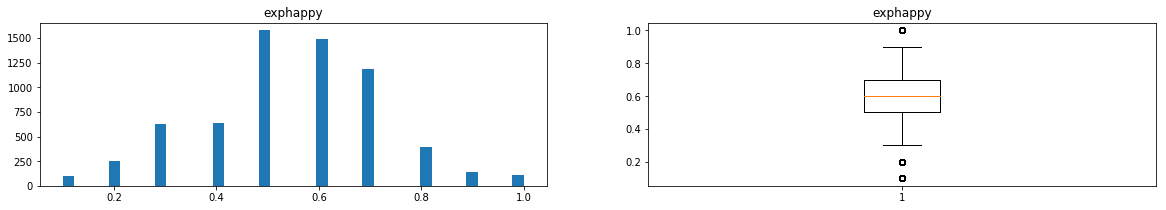

0 missing vals for attr1_1
Avg: 0.5


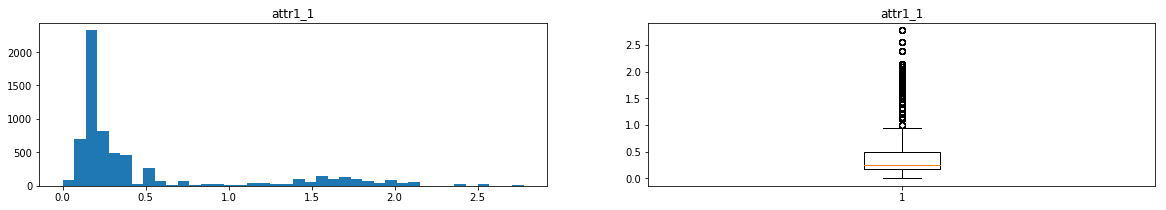

0 missing vals for sinc1_1
Avg: 0.47


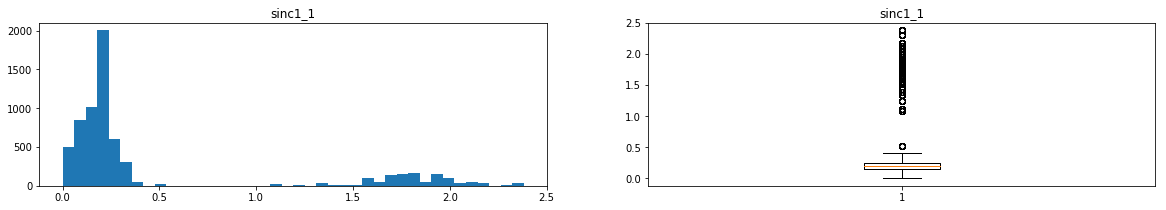

0 missing vals for intel1_1
Avg: 0.52


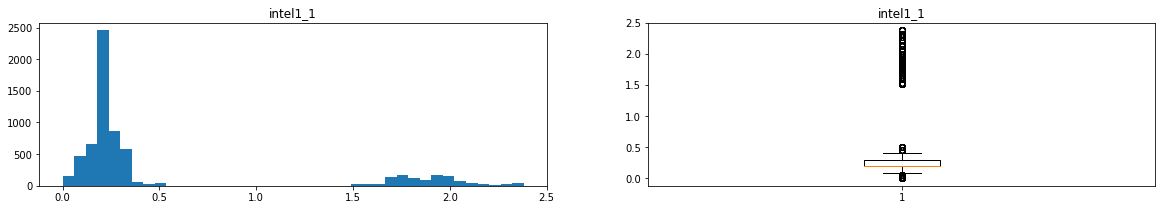

0 missing vals for fun1_1
Avg: 0.48


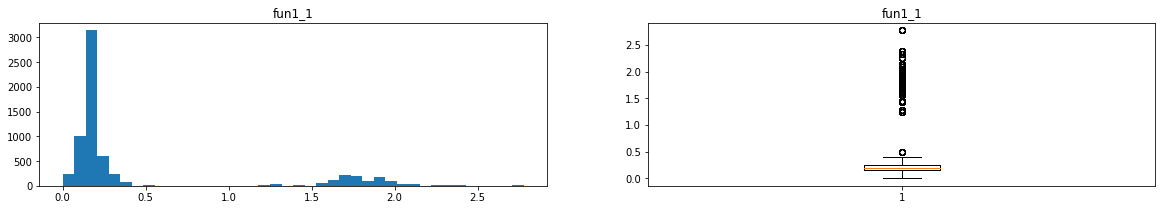

10 missing vals for amb1_1
Avg: 0.36


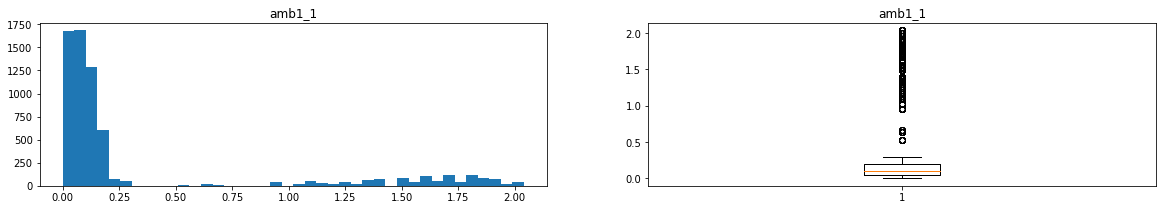

32 missing vals for shar1_1
Avg: 0.35


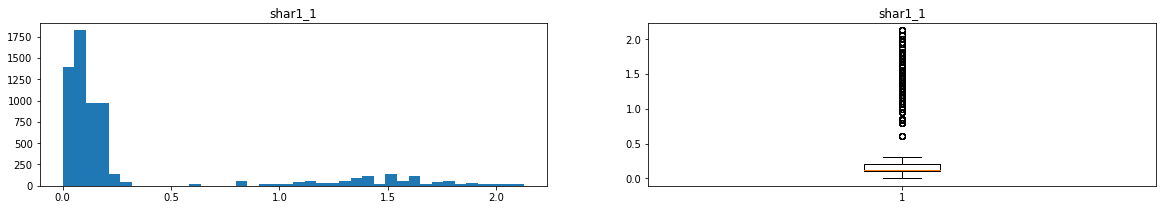

1573 missing vals for attr4_1
Avg: 0.46


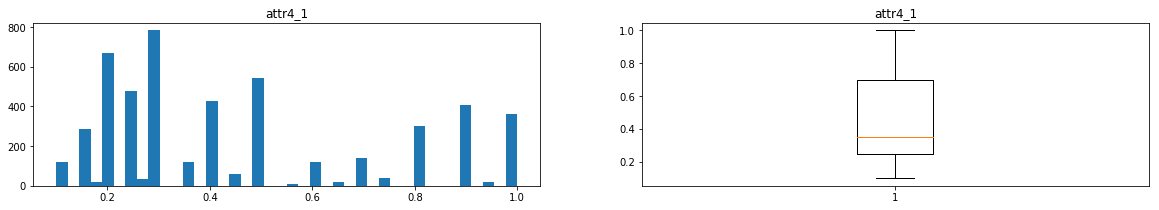

1573 missing vals for sinc4_1
Avg: 0.26


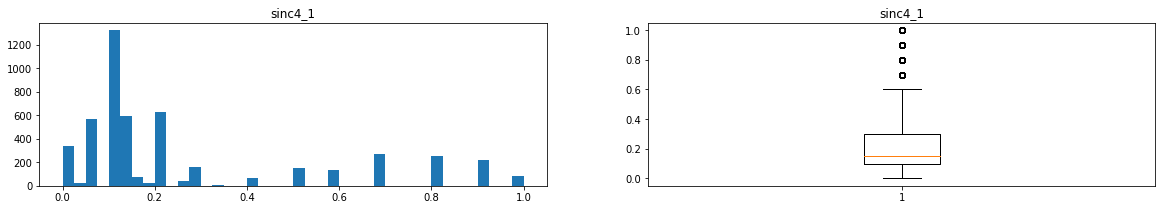

1573 missing vals for intel4_1
Avg: 0.28


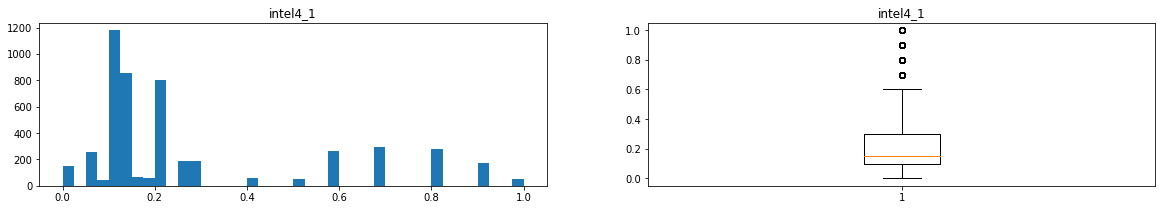

1573 missing vals for fun4_1
Avg: 0.33


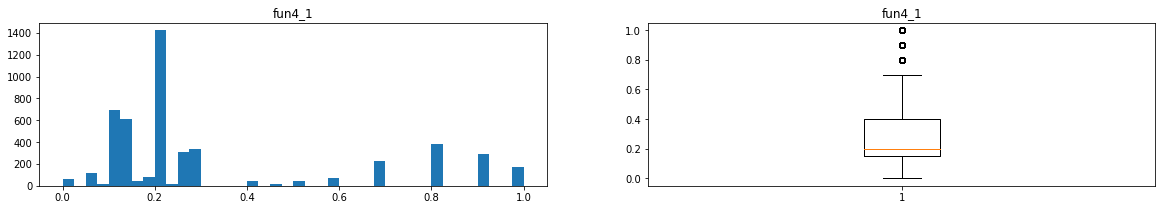

1573 missing vals for amb4_1
Avg: 0.24


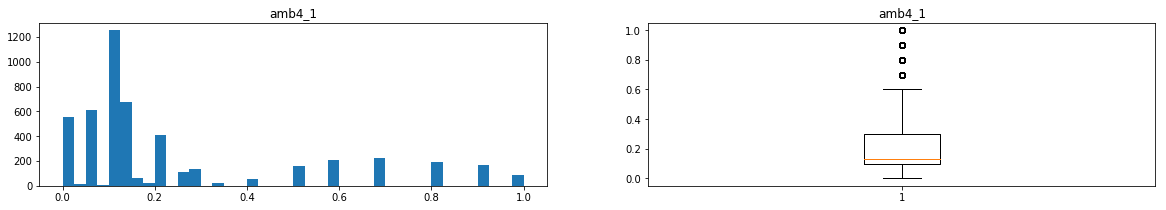

1595 missing vals for shar4_1
Avg: 0.26


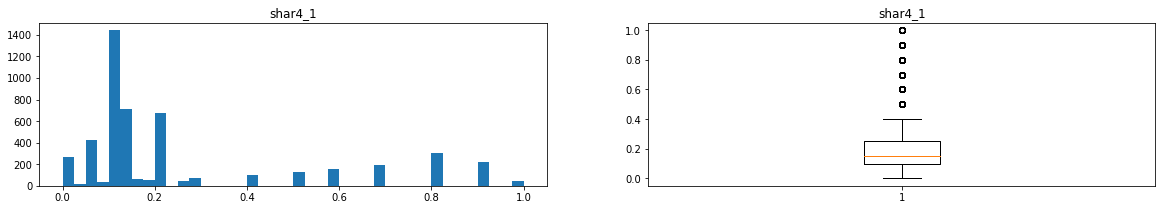

0 missing vals for attr2_1
Avg: 0.64


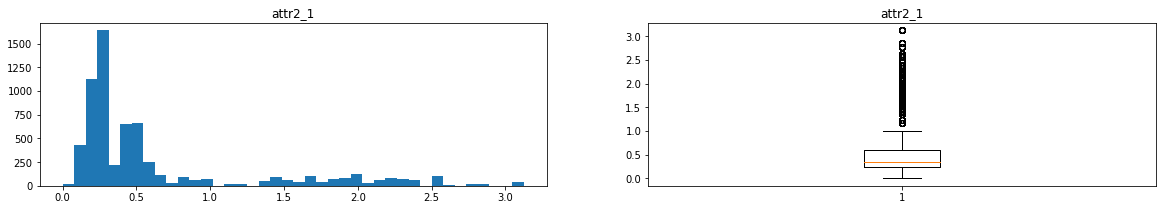

0 missing vals for sinc2_1
Avg: 0.4


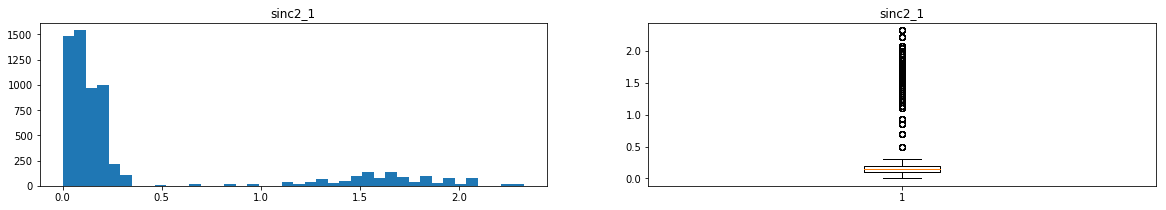

0 missing vals for intel2_1
Avg: 0.4


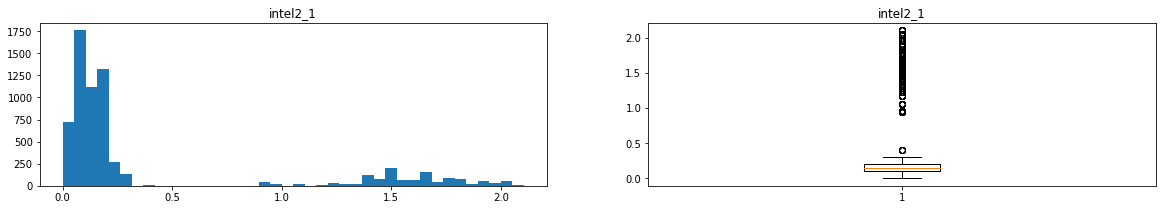

0 missing vals for fun2_1
Avg: 0.5


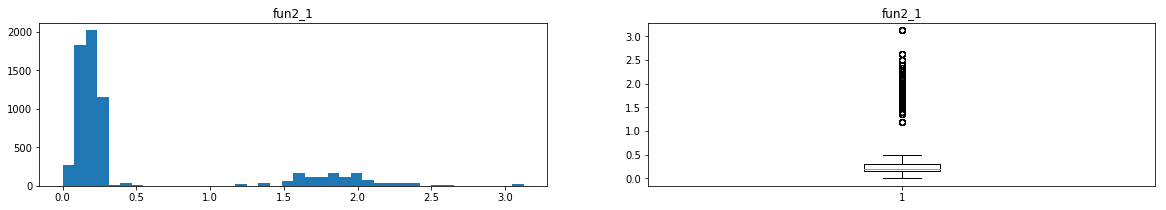

0 missing vals for amb2_1
Avg: 0.36


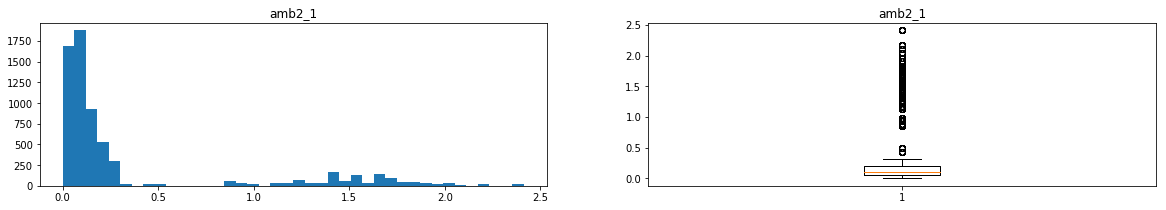

0 missing vals for shar2_1
Avg: 0.37


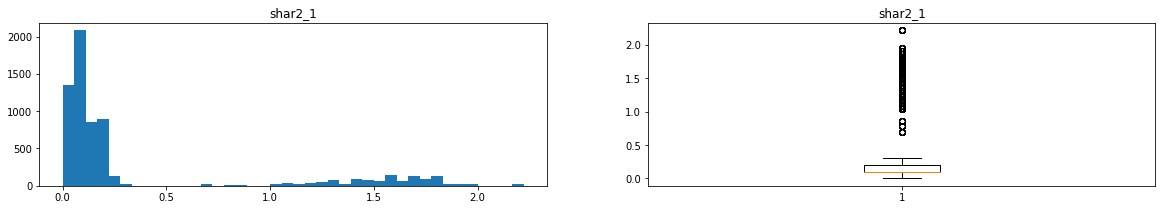

26 missing vals for attr3_1
Avg: 0.2


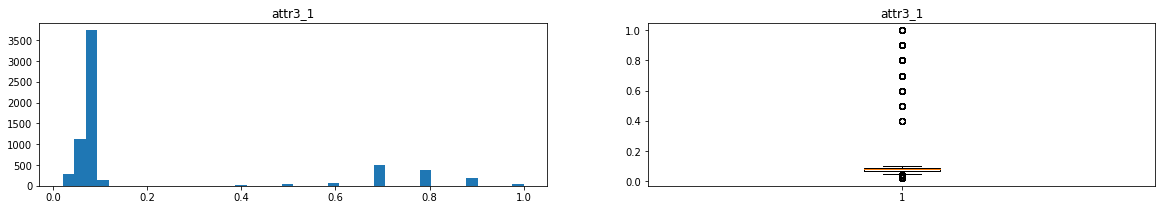

26 missing vals for sinc3_1
Avg: 0.22


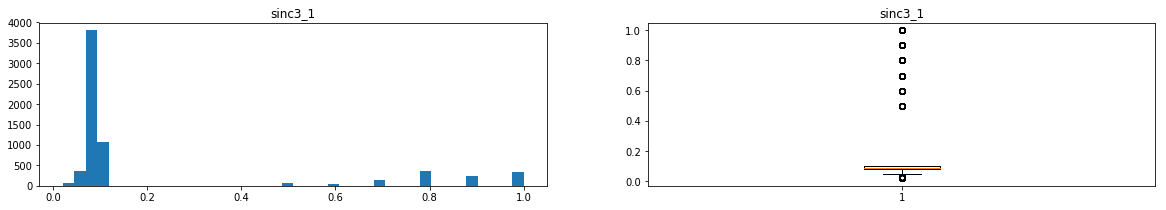

26 missing vals for fun3_1
Avg: 0.21


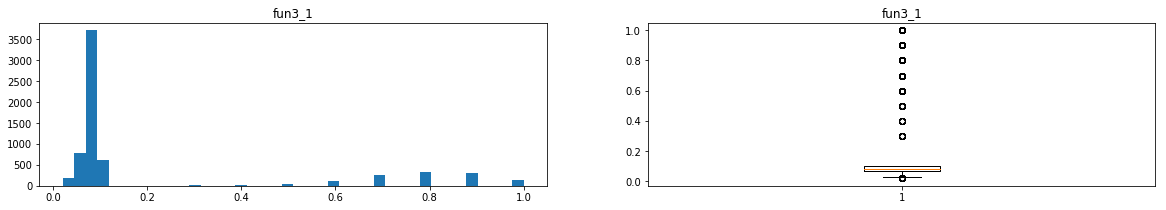

26 missing vals for intel3_1
Avg: 0.23


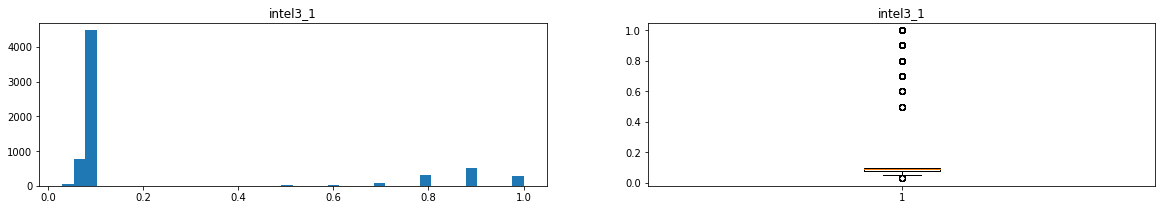

26 missing vals for amb3_1
Avg: 0.21


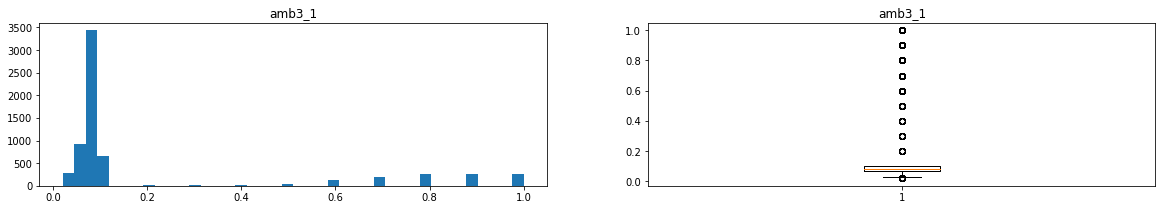

159 missing vals for attr
Avg: 0.17


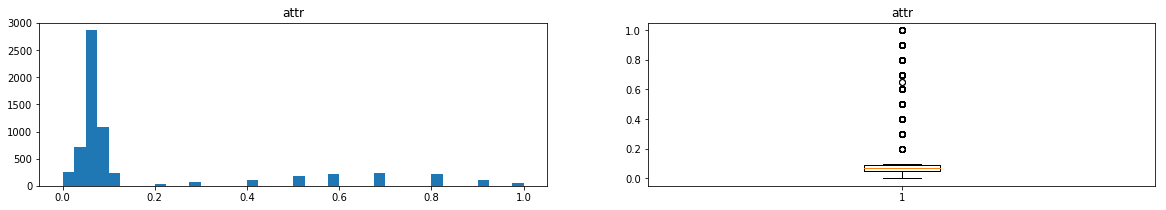

200 missing vals for sinc
Avg: 0.2


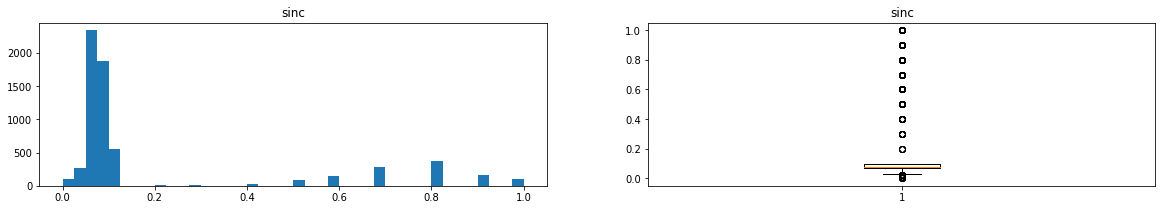

229 missing vals for intel
Avg: 0.2


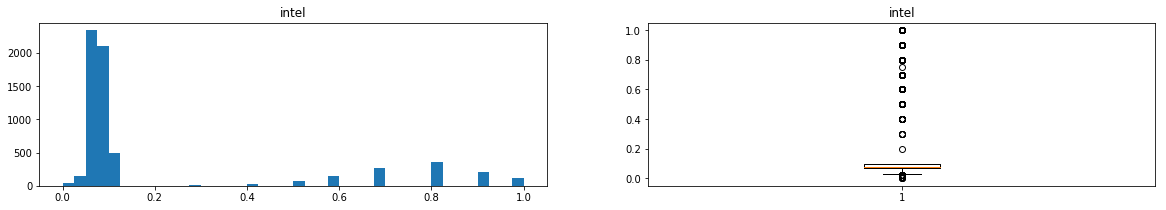

292 missing vals for fun
Avg: 0.18


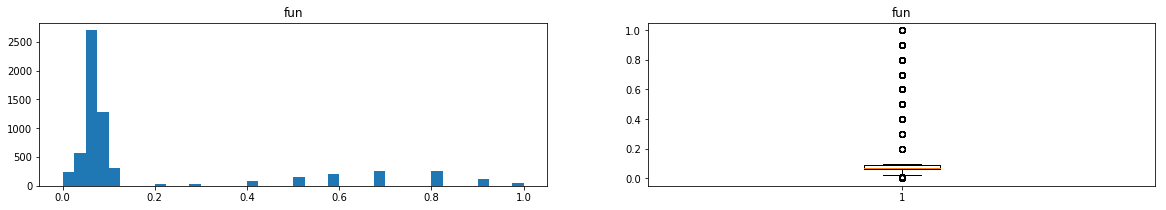

530 missing vals for amb
Avg: 0.19


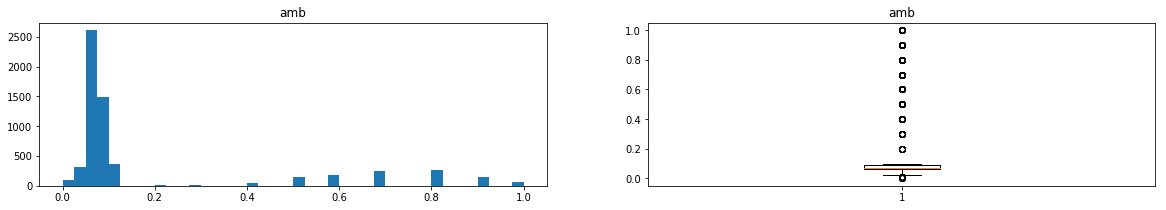

0 missing vals for shar
Avg: 0.15


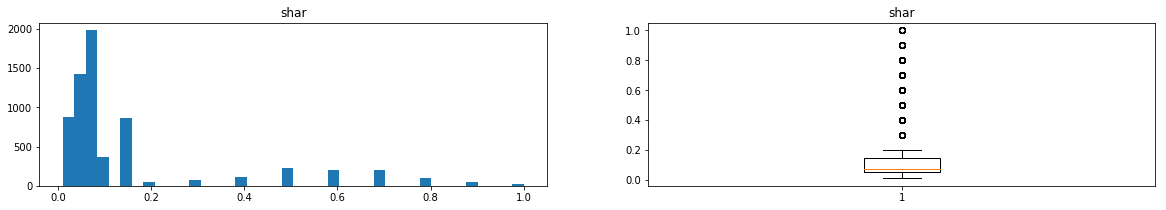

198 missing vals for like
Avg: 0.17


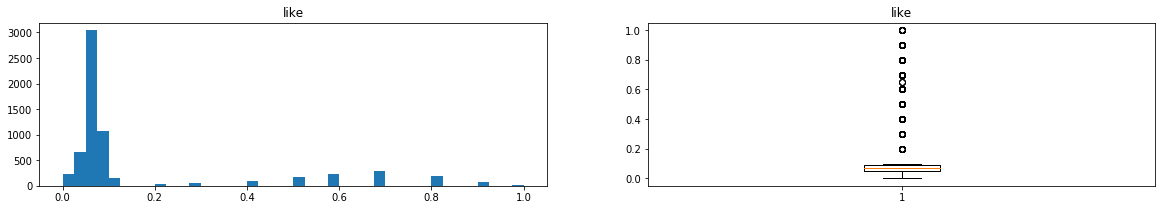

254 missing vals for prob
Avg: 0.14


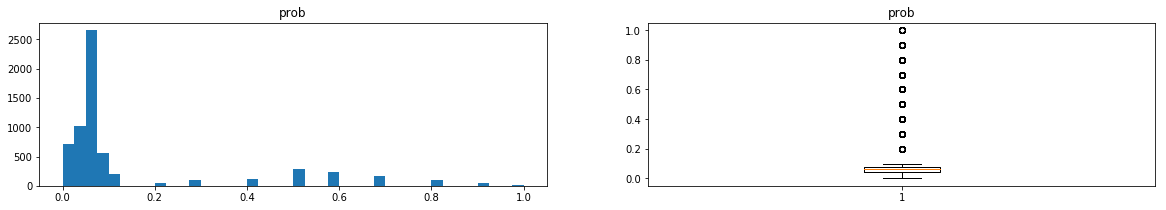

727 missing vals for satis_2
Avg: 0.56


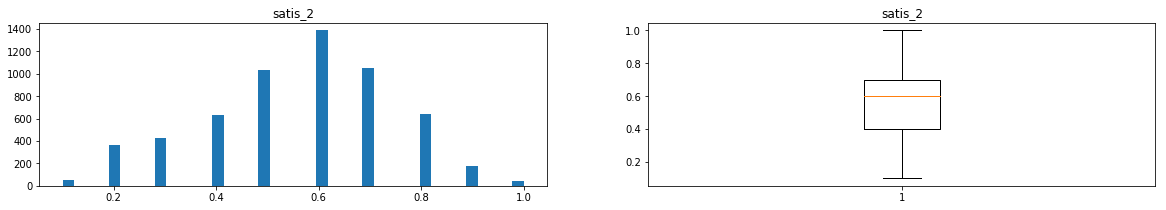

745 missing vals for attr1_2
Avg: 0.56


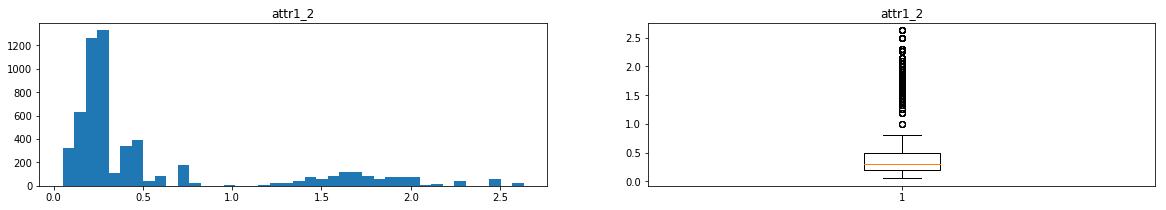

727 missing vals for sinc1_2
Avg: 0.45


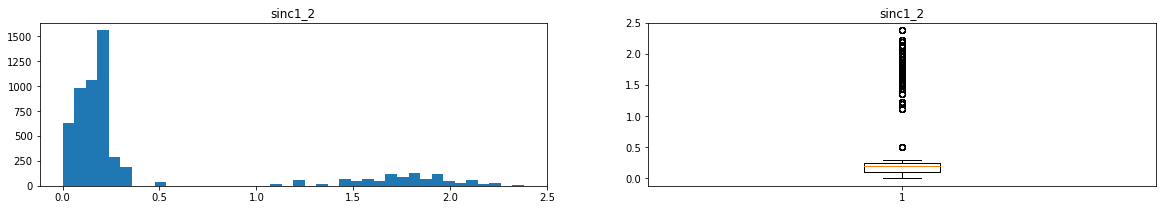

727 missing vals for intel1_2
Avg: 0.49


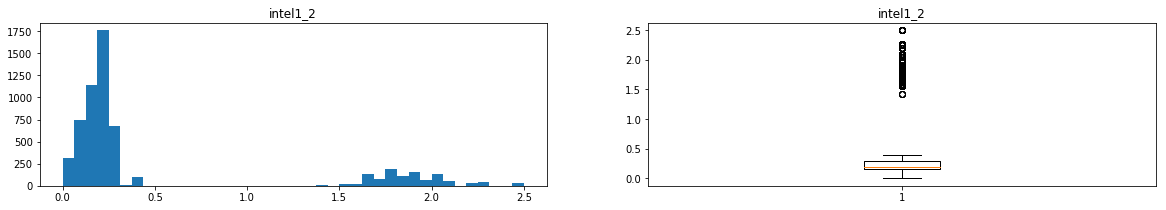

727 missing vals for fun1_2
Avg: 0.47


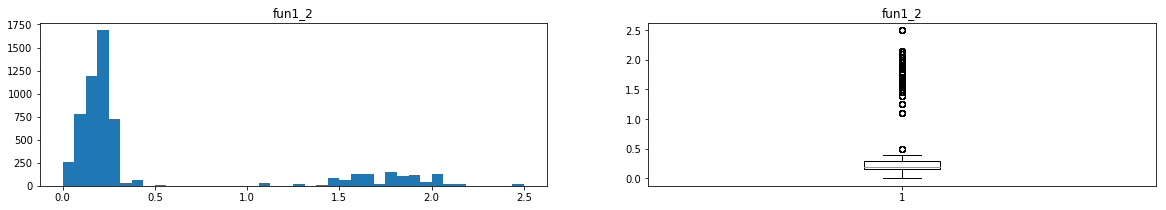

727 missing vals for amb1_2
Avg: 0.34


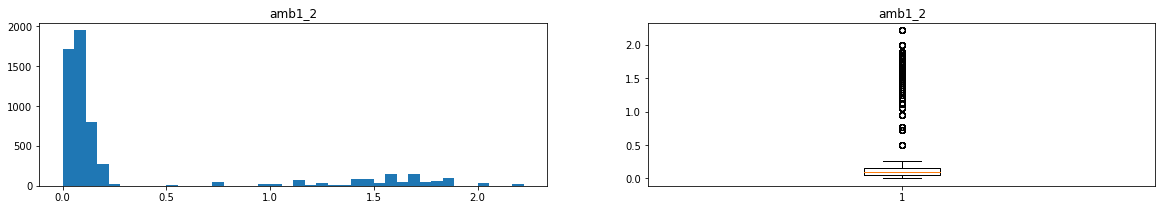

727 missing vals for shar1_2
Avg: 0.36


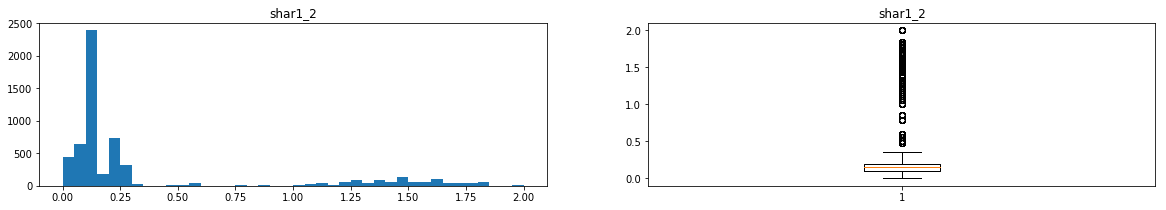

2178 missing vals for attr4_2
Avg: 0.46


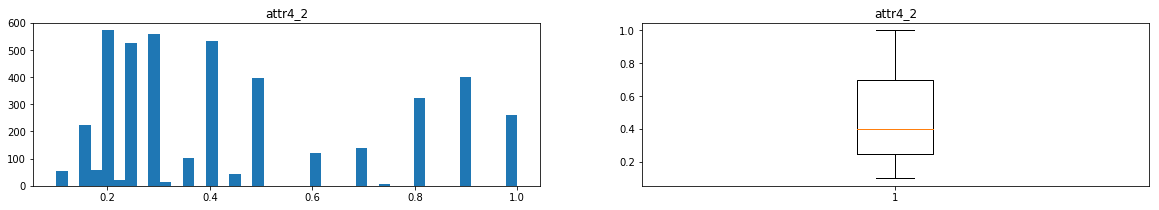

2178 missing vals for sinc4_2
Avg: 0.27


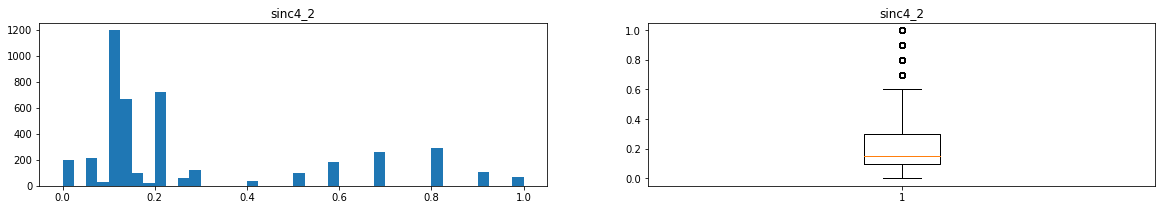

2178 missing vals for intel4_2
Avg: 0.27


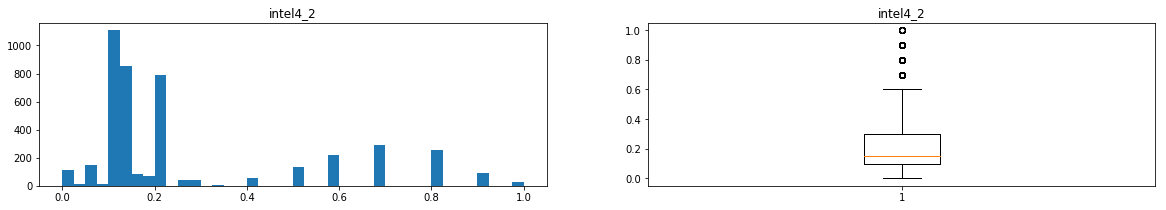

2178 missing vals for fun4_2
Avg: 0.33


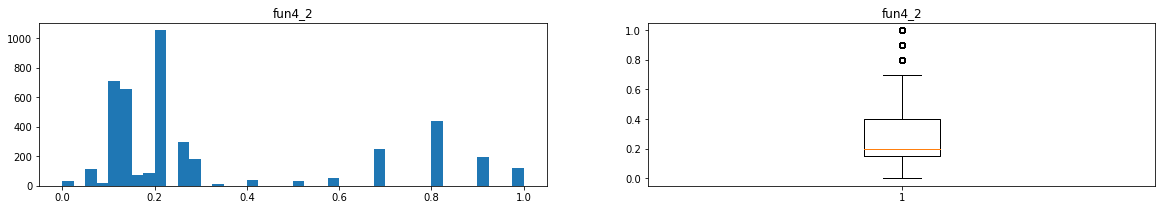

2178 missing vals for amb4_2
Avg: 0.24


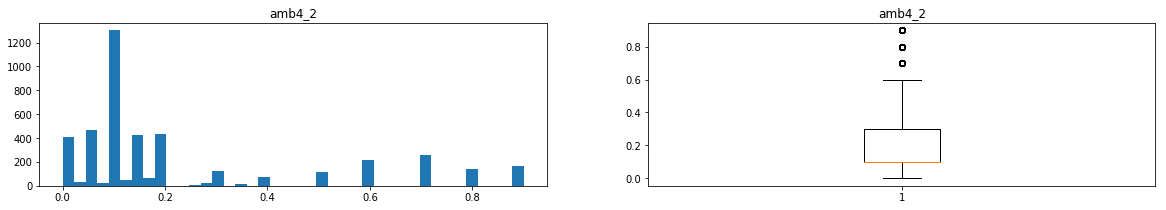

2178 missing vals for shar4_2
Avg: 0.27


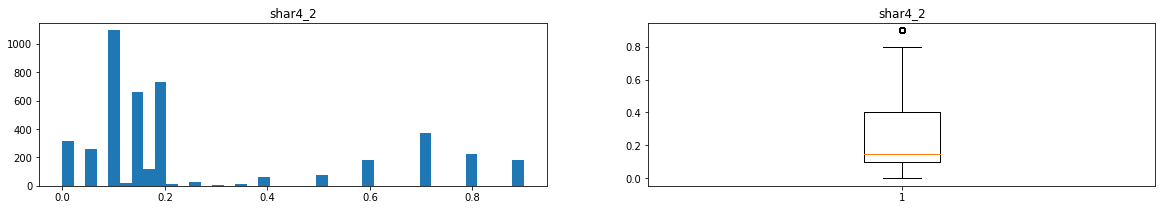

2178 missing vals for attr2_2
Avg: 0.72


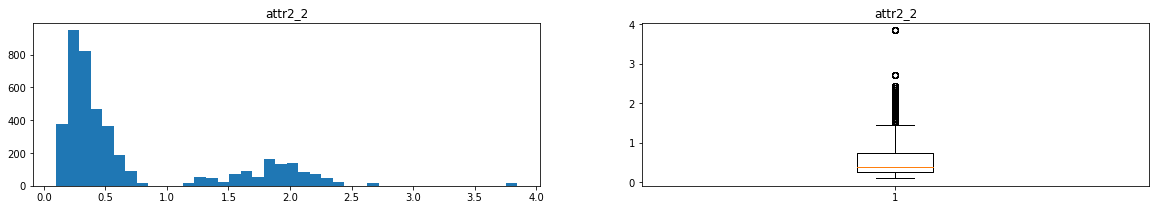

2178 missing vals for sinc2_2
Avg: 0.5


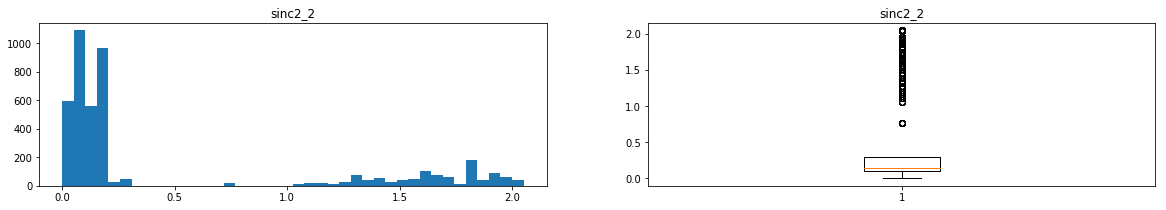

2178 missing vals for intel2_2
Avg: 0.5


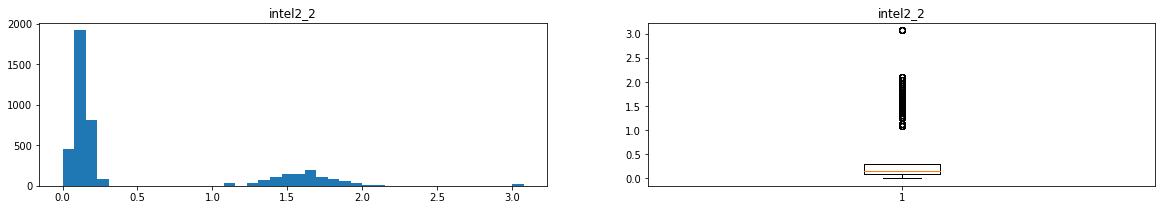

2178 missing vals for fun2_2
Avg: 0.58


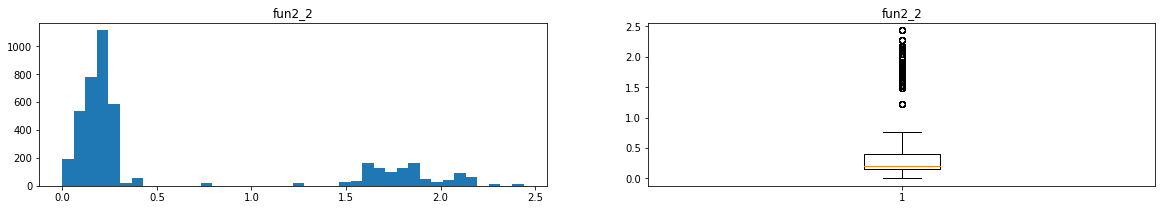

2178 missing vals for amb2_2
Avg: 0.46


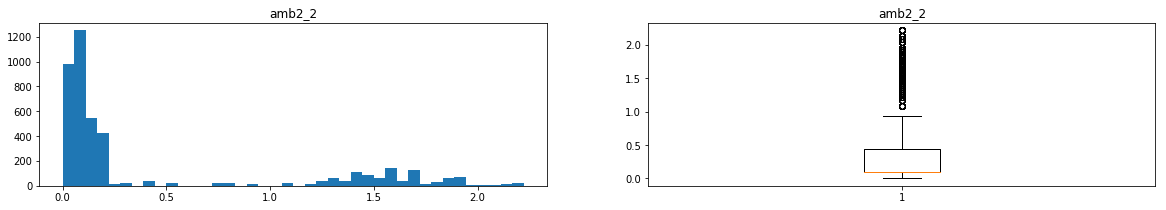

2178 missing vals for shar2_2
Avg: 0.47


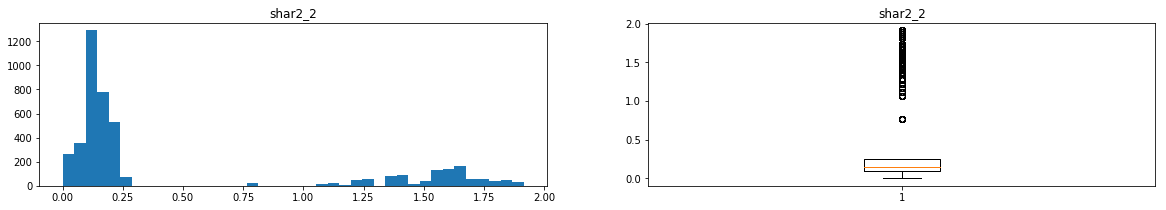

727 missing vals for attr3_2
Avg: 0.2


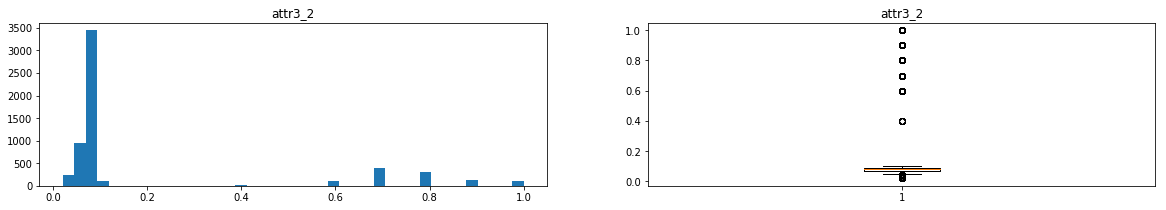

727 missing vals for sinc3_2
Avg: 0.22


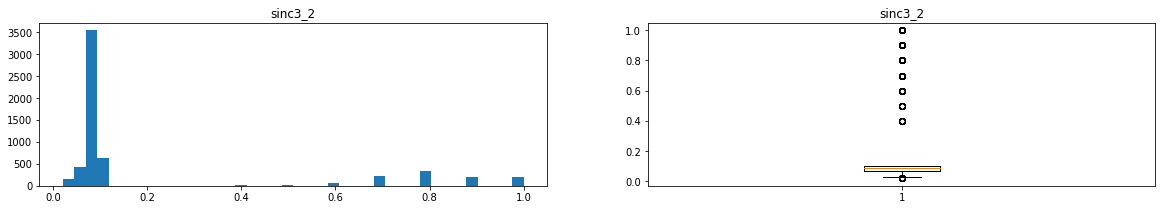

727 missing vals for intel3_2
Avg: 0.23


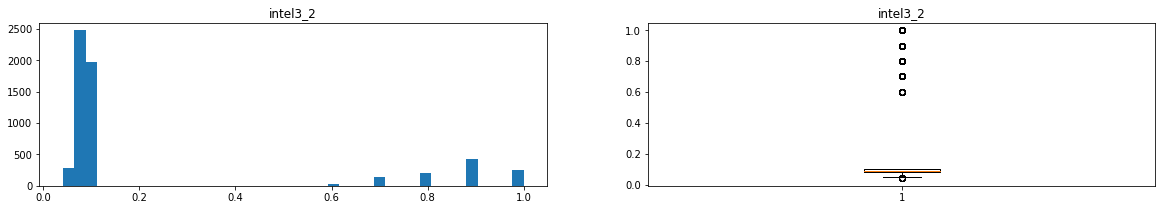

727 missing vals for fun3_2
Avg: 0.2


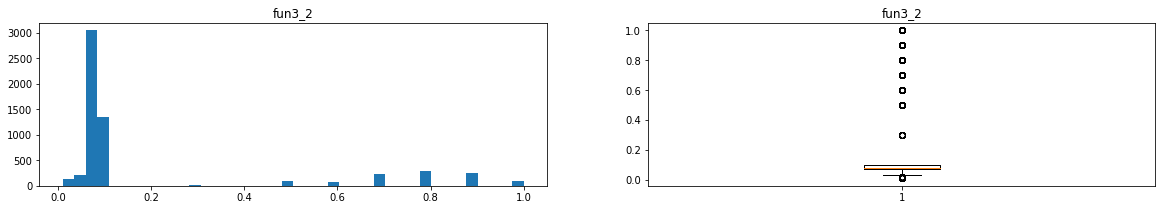

727 missing vals for amb3_2
Avg: 0.2


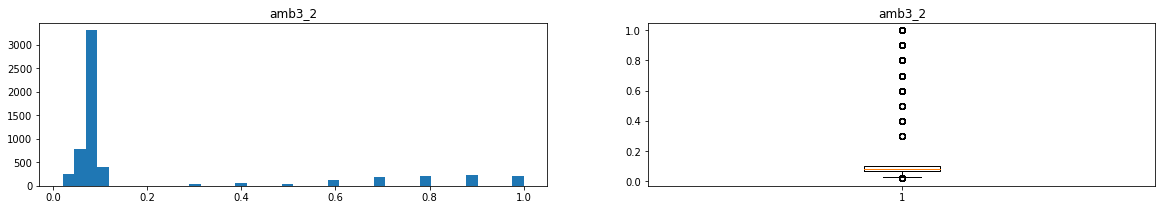

0 missing vals for male_older
Avg: 0.24


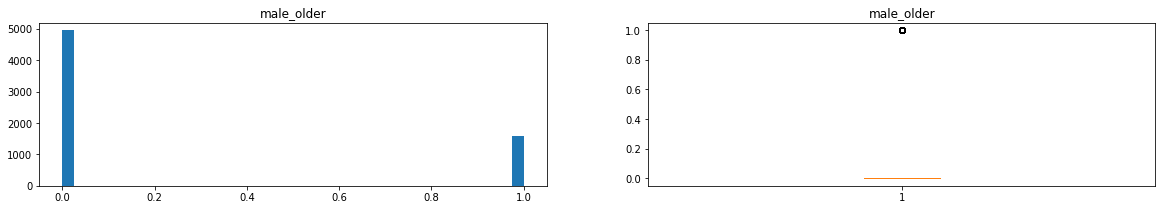

970 missing vals for match_es_perc
Avg: 0.2


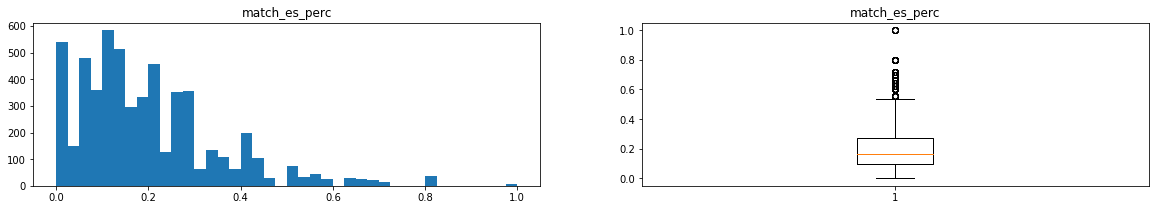

32 missing vals for age_diff
Avg: 0.0


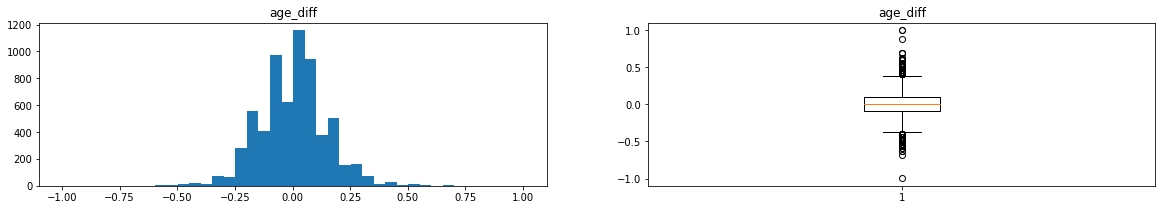

0 missing vals for gender_0
Avg: 0.53


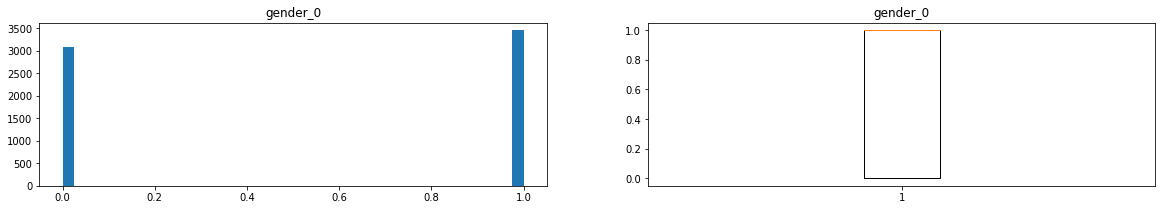

0 missing vals for gender_1
Avg: 0.47


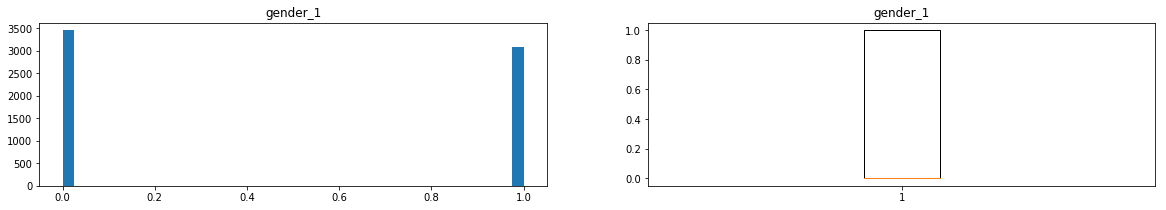

0 missing vals for condtn_1
Avg: 0.15


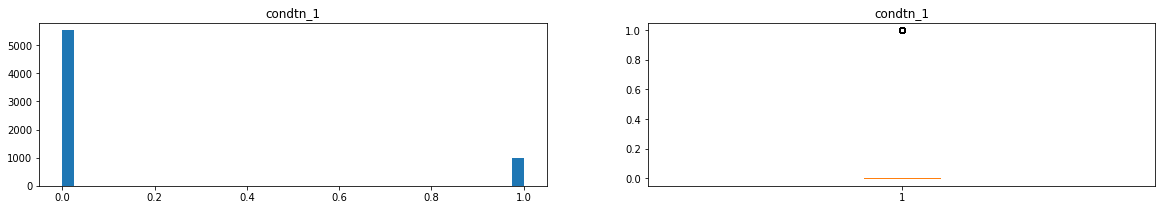

0 missing vals for condtn_2
Avg: 0.85


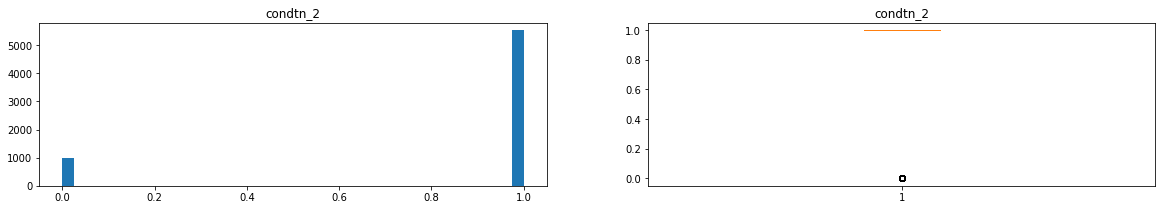

0 missing vals for samerace_0
Avg: 0.58


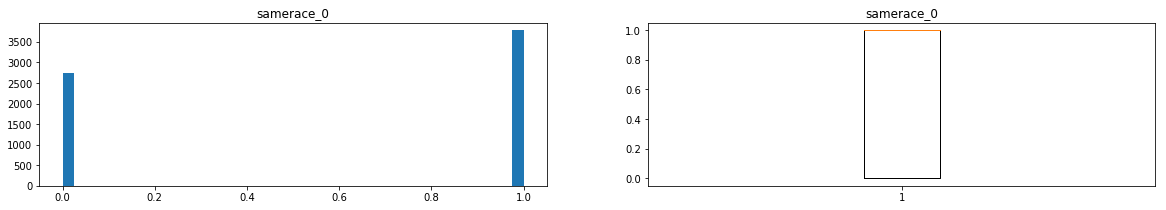

0 missing vals for samerace_1
Avg: 0.42


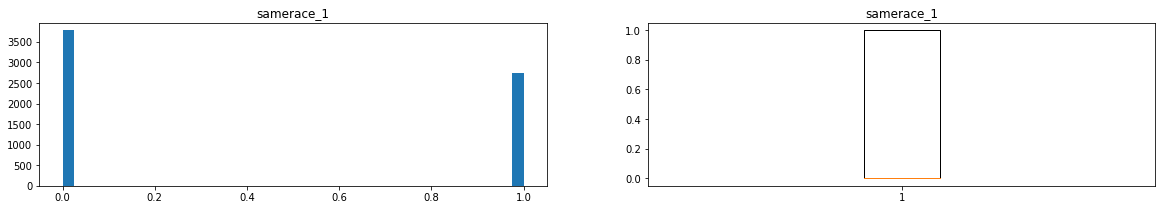

159 missing vals for diff_my_attr
Avg: 0.34


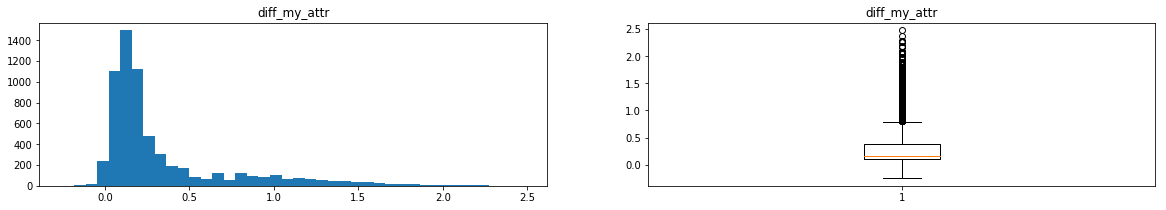

200 missing vals for diff_my_sinc
Avg: 0.28


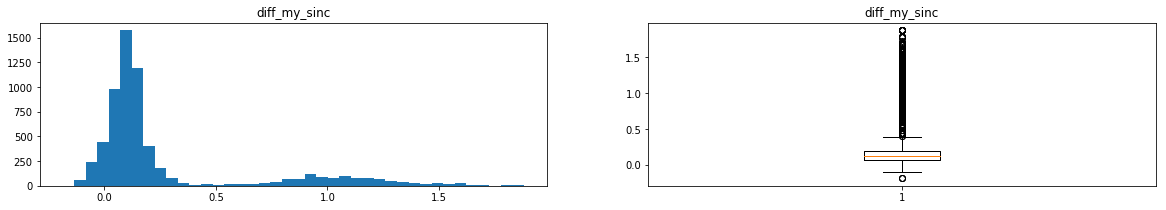

229 missing vals for diff_my_intel
Avg: 0.32


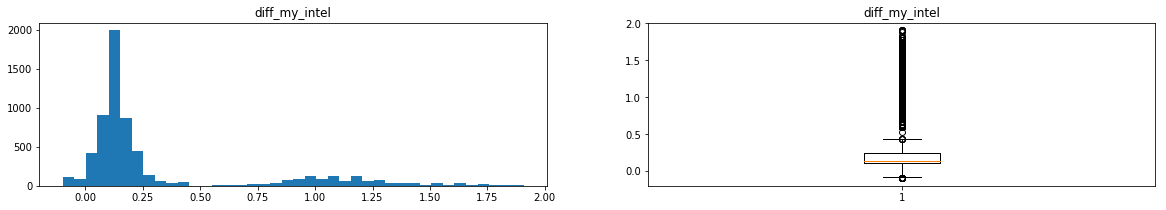

292 missing vals for diff_my_fun
Avg: 0.3


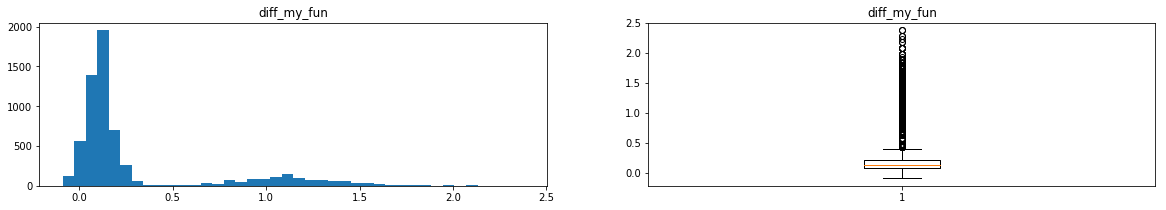

539 missing vals for diff_my_amb
Avg: 0.18


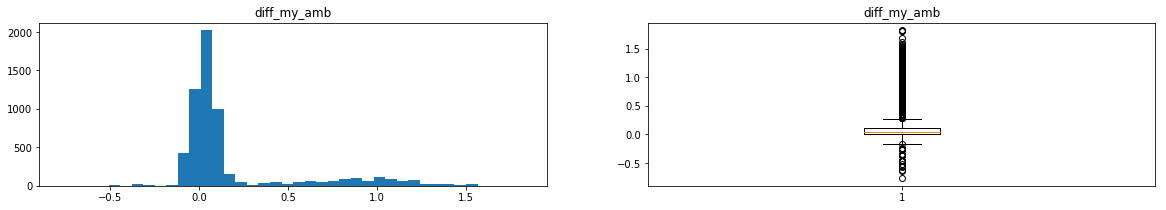

32 missing vals for diff_my_shar
Avg: 0.2


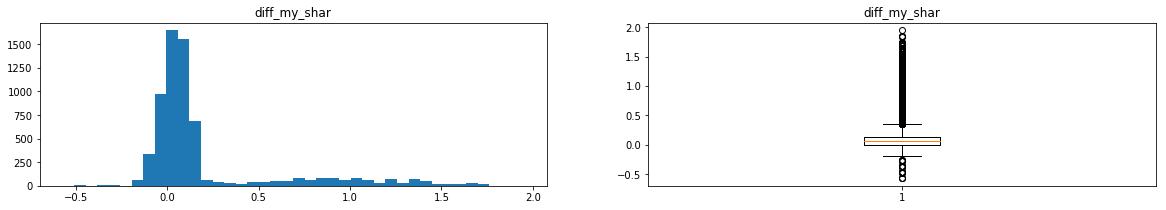

214 missing vals for diff_partners_attr_o
Avg: 0.33


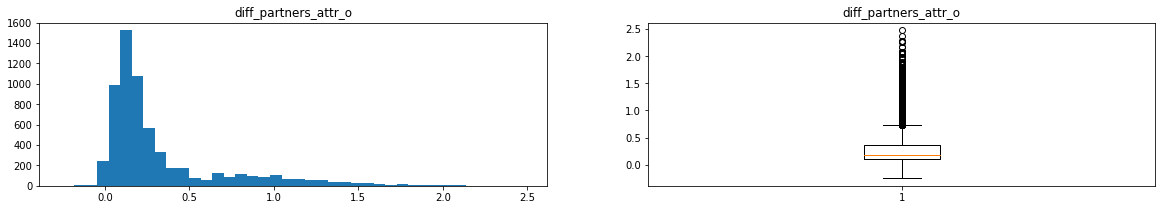

265 missing vals for diff_partners_sinc_o
Avg: 0.28


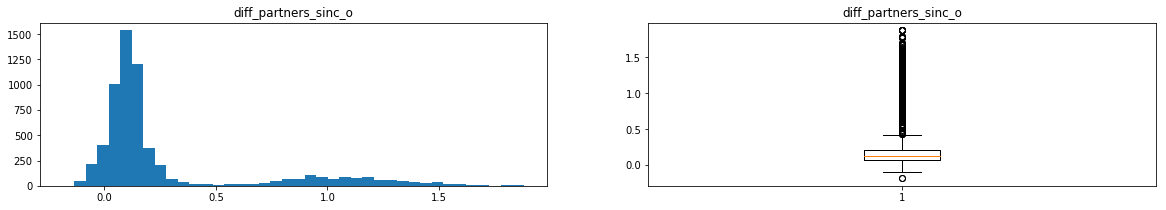

284 missing vals for diff_partners_intel_o
Avg: 0.33


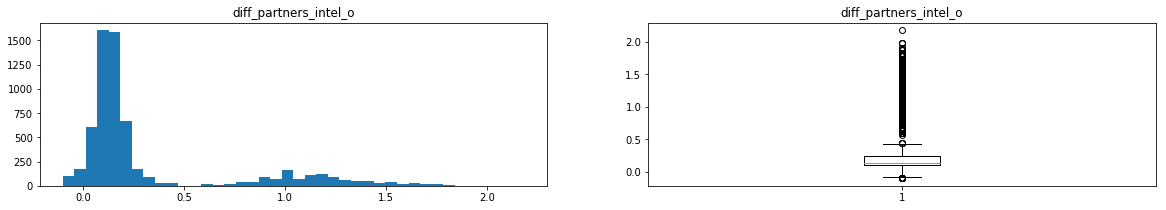

339 missing vals for diff_partners_fun_o
Avg: 0.3


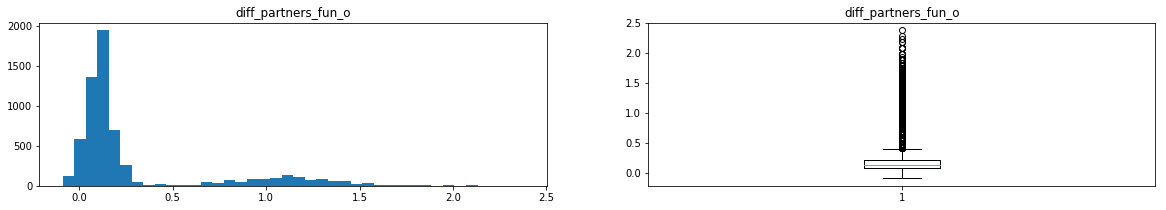

621 missing vals for diff_partners_amb_o
Avg: 0.17


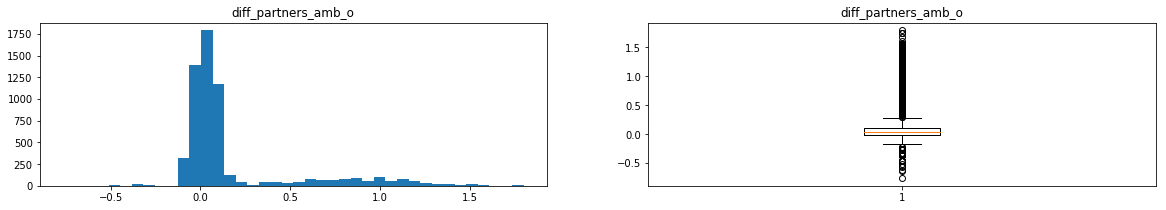

91 missing vals for diff_partners_shar_o
Avg: 0.21


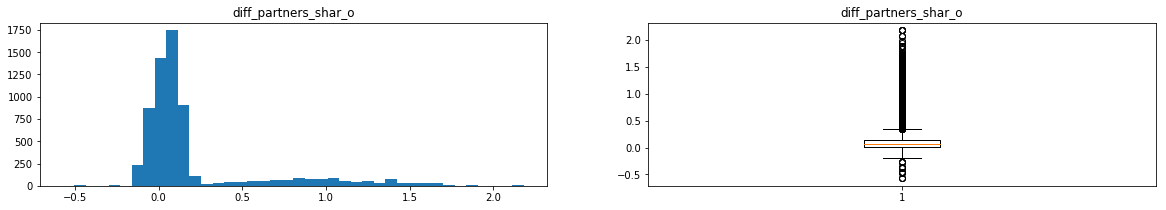

1353 rows(20.72%) dropped
5178 rows (79.28%) left


,iid,match,int_corr,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,attr_o,...,diff_my_intel,diff_my_fun,diff_my_amb,diff_my_shar,diff_partners_attr_o,diff_partners_sinc_o,diff_partners_intel_o,diff_partners_fun_o,diff_partners_amb_o,diff_partners_shar_o
1,1,0,0.54,0.60,0.471797,0.521506,0.40,0.352616,0.359556,0.07,...,0.13,0.07,0.10,0.09,0.53,0.281619,0.326072,0.33,0.171435,0.207122
2,1,1,0.16,0.19,0.180000,0.190000,0.18,0.140000,0.120000,0.10,...,0.11,0.07,0.10,0.08,0.09,0.080000,0.090000,0.08,0.040000,0.020000
3,1,1,0.61,0.30,0.050000,0.150000,0.40,0.050000,0.050000,0.07,...,0.12,0.08,0.09,0.07,0.23,0.281619,0.060000,0.32,0.171435,0.207122
4,1,1,0.21,0.30,0.100000,0.200000,0.10,0.100000,0.200000,0.08,...,0.13,0.08,0.09,0.09,0.22,0.030000,0.110000,0.04,0.010000,0.130000
5,1,0,0.25,0.50,0.471797,0.300000,0.10,0.352616,0.100000,0.07,...,0.13,0.11,0.09,0.11,0.43,0.281619,0.220000,0.02,0.171435,0.030000


In [12]:
# Drop rows with null values
def drop_nulls(df):
    old_num = df.shape[0]
    df = df.dropna(axis=0)
    
    num_dropped = old_num - df.shape[0]
    perc_dropped = round(num_dropped / old_num * 100, 2)
    print('{} rows({}%) dropped'.format(num_dropped, perc_dropped))
    
    perc_left = round(df.shape[0] / old_num * 100, 2)
    print('{} rows ({}%) left'.format(df.shape[0], perc_left))
    return df

cols_to_impute = list(filter(lambda x: ((x not in ['match', 'iid', 'zipcode']) and (not x.startswith('from_')) and (not x.startswith('in_')) and (not x.startswith('same_'))), raw_data.columns))
raw_data = visualize_to_impute(raw_data, cols_to_impute)

# Instead of dropping nulls, could one corroborate with the person's partner's row?
# print(df.isnull().sum().sort_values(ascending=False))

raw_data = drop_nulls(raw_data)

raw_data.head()

In [13]:
df = raw_data.copy()

matches = df[df['match'] == 1]
non_matches = df[df['match'] == 0]

num_matches = matches.shape[0]
num_non_matches = non_matches.shape[0]
perc_minority = round(num_matches / df.shape[0] * 100, 2)
perc_majority = round(num_non_matches / df.shape[0] * 100, 2)

print(('{} TOTAL: \n   {} matches ({}%)\n   {} non-matches ({}%)').format(df.shape[0], num_matches, perc_minority, num_non_matches, perc_majority))

5178 TOTAL: 
   896 matches (17.3%)
   4282 non-matches (82.7%)


## Data Visualization Helper Methods

In [14]:
def show_distributions(df):
    plt.figure(figsize=(20, 3))
    
    matches = df[df['match'] == 1]
    non_matches = df[df['match'] == 0]

    for idx, col in enumerate(cols_of_interest):
        plt.subplot(1, 6, idx + 1)
        plt.hist(matches[col], alpha=0.4, bins= 20, color='green', label='matches')
        plt.hist(non_matches[col], alpha=0.4, bins= 20, color='red', label='non-matches')
        plt.legend()
        plt.title(col)

    plt.show()

def show_boxplots(df):
    plt.figure(figsize=(20, 3))
    
    matches = df[df['match'] == 1]
    non_matches = df[df['match'] == 0]

    for idx, col in enumerate(cols_of_interest):
        plt.subplot(1, 6, idx + 1)
        plt.boxplot([matches[col], non_matches[col]])
        plt.title(col + ' - matches vs. non-matc.')

    plt.show()

In [15]:
# TODO: clean to see if improves score
df.zipcode = pd.to_numeric(df.zipcode)
df.drop(columns=['zipcode'], inplace=True)
df.head()

,iid,match,int_corr,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,attr_o,...,diff_my_intel,diff_my_fun,diff_my_amb,diff_my_shar,diff_partners_attr_o,diff_partners_sinc_o,diff_partners_intel_o,diff_partners_fun_o,diff_partners_amb_o,diff_partners_shar_o
1,1,0,0.54,0.60,0.471797,0.521506,0.40,0.352616,0.359556,0.07,...,0.13,0.07,0.10,0.09,0.53,0.281619,0.326072,0.33,0.171435,0.207122
2,1,1,0.16,0.19,0.180000,0.190000,0.18,0.140000,0.120000,0.10,...,0.11,0.07,0.10,0.08,0.09,0.080000,0.090000,0.08,0.040000,0.020000
3,1,1,0.61,0.30,0.050000,0.150000,0.40,0.050000,0.050000,0.07,...,0.12,0.08,0.09,0.07,0.23,0.281619,0.060000,0.32,0.171435,0.207122
4,1,1,0.21,0.30,0.100000,0.200000,0.10,0.100000,0.200000,0.08,...,0.13,0.08,0.09,0.09,0.22,0.030000,0.110000,0.04,0.010000,0.130000
5,1,0,0.25,0.50,0.471797,0.300000,0.10,0.352616,0.100000,0.07,...,0.13,0.11,0.09,0.11,0.43,0.281619,0.220000,0.02,0.171435,0.030000


## Over-Sampling to Counter Skewed Data

Because my dataset is so skewed in favor of non-matches, I will be over-sampling from my smaller group (matches) in order to train my models accurately.

In [16]:
# cols_of_interest = df.columns[df.columns != 'match']
# cols_of_interest = ['iid', 'pf_o_amb', 'pf_o_sha', 'attr_o', 'intel_o', 'fun_o', 'shar_o',
#        'like_o', 'prob_o', 'attr', 'intel', 'fun', 'shar', 'like', 'prob',
#        'sinc1_2', 'match_es_perc', 'diff_my_fun', 'diff_my_amb',
#        'diff_my_shar', 'diff_partners_intel_o', 'diff_partners_fun_o']
cols_of_interest = ['iid', 'attr_o', 'fun_o', 'like_o', 'prob_o', 'attr', 'like']

High scorers: [14, 19, 35, 49, 77, 86, 91, 92, 99, 105, 107, 109, 112, 125, 128, 142, 154, 169, 208, 212, 215, 217, 258, 260, 268, 269, 277, 316, 354, 364, 366, 369, 384, 387, 389, 398, 400, 404, 414, 448, 467, 469, 470, 489, 492, 509, 513, 516, 521, 524, 535, 546, 552]


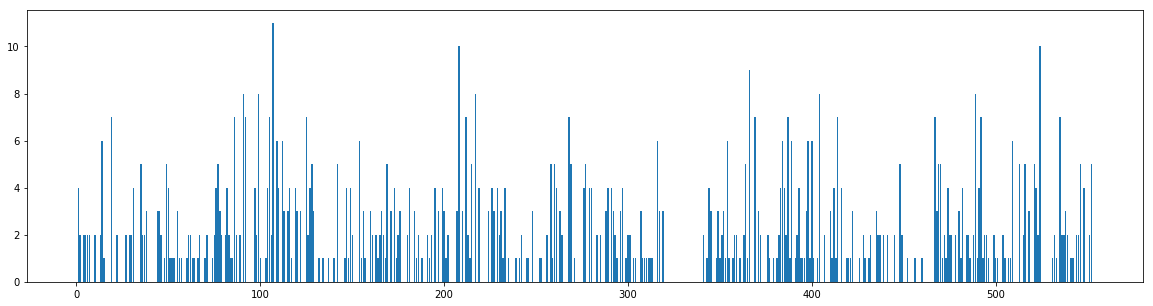

In [17]:
# Cheating to use iid?
match_totals = df.groupby('iid').sum()['match']
all_iids = list(match_totals.index)
over_4_matches = list(map(lambda x: x >= 5, match_totals))
print('High scorers:', list(compress(all_iids, over_4_matches)))

plt.figure(figsize=(20,5))
plt.bar(all_iids, height=match_totals)
plt.show()

In [18]:
df.drop(columns='iid', inplace=True)
cols_of_interest = list(filter(lambda col: col != 'iid', cols_of_interest))

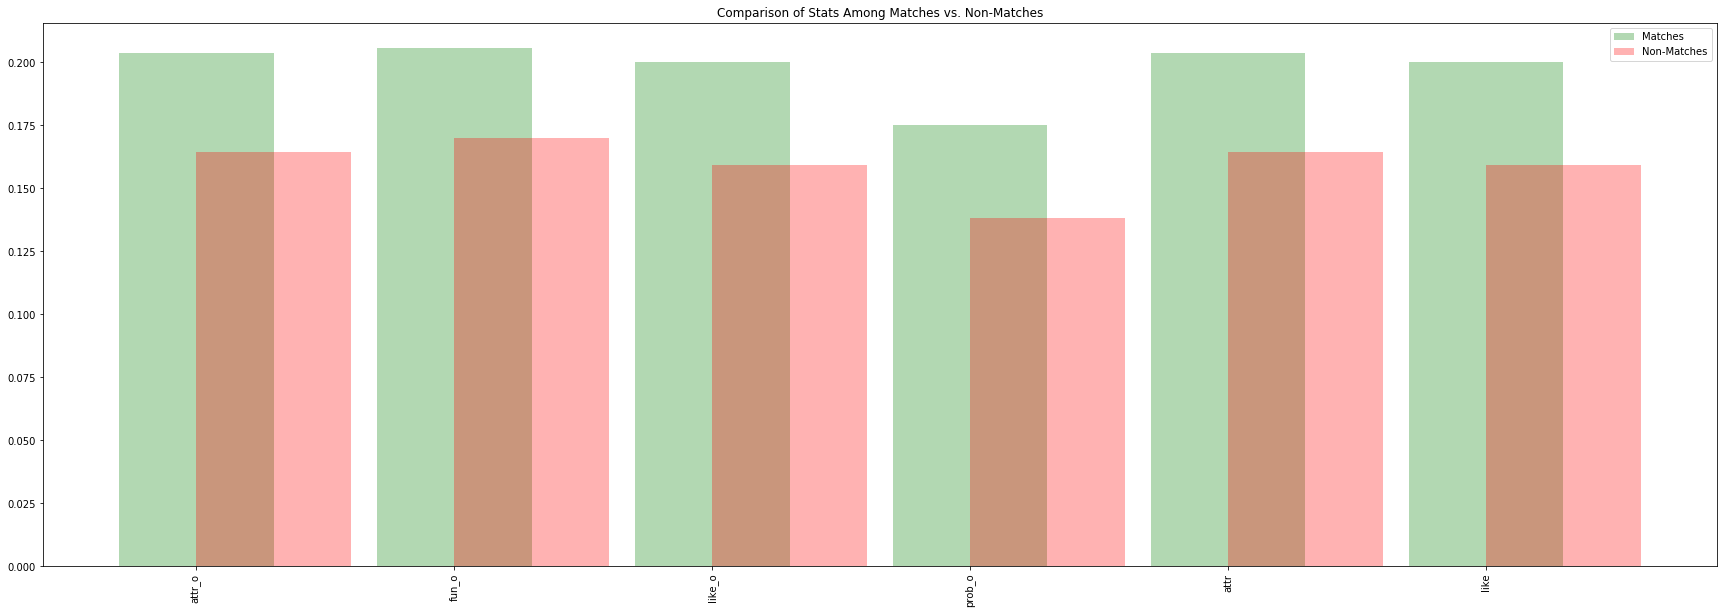

In [19]:
matches = df[df['match'] == 1]
non_matches = df[df['match'] == 0]

plt.figure(figsize=(30,10))

plt.bar(cols_of_interest, height=matches[cols_of_interest].mean(), width=0.6, color='green', alpha=0.3, label='Matches')
plt.bar(cols_of_interest, height=non_matches[cols_of_interest].mean(), width=0.6, color='red', align='edge', alpha=0.3, label='Non-Matches')
plt.title('Comparison of Stats Among Matches vs. Non-Matches')
plt.xticks(rotation=90)
plt.legend()

plt.show()

In [20]:
train_df = df.loc[::2, cols_of_interest + ['match']]
test_df = df.loc[1::2, cols_of_interest + ['match']]

In [21]:
X = df.loc[:, cols_of_interest]
Y = df['match']

X_train = train_df.loc[:, cols_of_interest]
Y_train = train_df['match']

X_test = test_df.loc[:, cols_of_interest]
Y_test = test_df['match']

sm = SMOTE(random_state=1, ratio = 1.0)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)

print(Counter(Y_train_res))

oversampled_X_train, oversampled_X_test, oversampled_Y_train, oversampled_Y_test = train_test_split(X_train_res, Y_train_res, test_size=0.25, random_state=1)

Counter({0: 2141, 1: 2141})


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [22]:
df = pd.DataFrame(data = oversampled_X_train, columns=cols_of_interest)
df['match'] = oversampled_Y_train

df.head()

,attr_o,fun_o,like_o,prob_o,attr,like,match
0,0.070000,0.070632,0.08,0.050632,0.069368,0.10,1
1,0.050000,0.080000,0.06,0.020000,0.070000,0.09,0
2,0.080000,0.078455,0.07,0.070000,0.070000,0.07,1
3,0.060000,0.050000,0.04,0.030000,0.050000,0.03,0
4,0.080779,0.070779,0.06,0.040779,0.060000,0.07,1


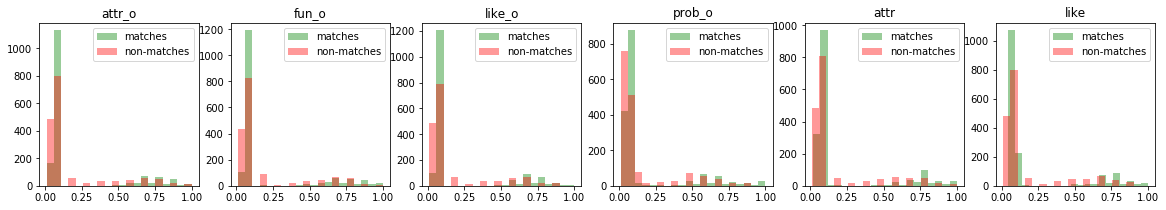

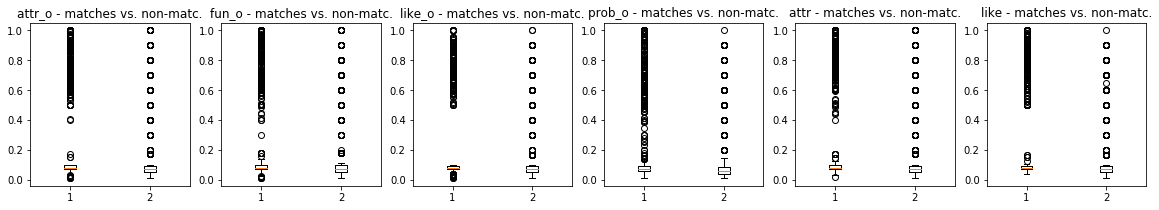

In [23]:
show_distributions(df)
show_boxplots(df)

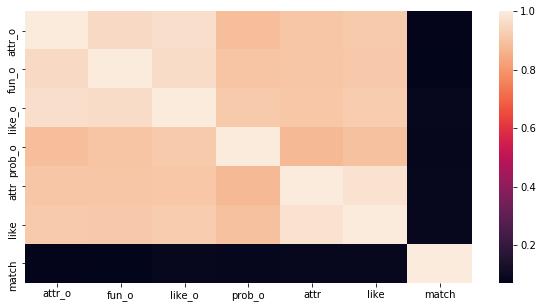

In [24]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr())
plt.show()

# Model for Target

Try several different approaches and work to tune a variety of models before using the model evaluation techniques to choose what you consider to be the best performer. 

Think about explanatory versus predictive power and experiment with both.

In [25]:
def get_errors(crosstab):
    tI_errors = crosstab.loc[0,1] / crosstab.loc['All','All'] * 100
    tII_errors = crosstab.loc[1,0] / crosstab.loc['All','All'] * 100
    print(('\nType I errors: {}%\nType II errors: {}%\n').format(round(tI_errors, 2), round(tII_errors, 2)))
    
def get_precision_recall(crosstab):
    precision = crosstab.loc[1,1] / crosstab.loc['All', 1] * 100 
    recall = crosstab.loc[1,1] / crosstab.loc[1,'All'] * 100 
    print(('Precision: {}%\nRecall: {}%').format(round(precision, 2), round(recall, 2)))

def fit_and_train(model):
    model_fit = model.fit(oversampled_X_train, oversampled_Y_train)
    model_score_train = model.score(oversampled_X_test, oversampled_Y_test)
    print('***TRAIN***')
    print('R² for train:', model_score_train)
    
    train_crosstab = pd.crosstab(oversampled_Y_train, model_fit.predict(oversampled_X_train), rownames=['actual'], colnames=['predicted'], margins=True)
    print(train_crosstab)
    
    get_errors(train_crosstab)
    get_precision_recall(train_crosstab)
    
    model_score_test = model.score(X_test, Y_test)
    print('\n***TEST***')
    print('R² for test:', model_score_test)
    
    test_crosstab = pd.crosstab(Y_test, model_fit.predict(X_test), rownames=['actual'], colnames=['predicted'], margins=True)
    print(test_crosstab)
    
    get_errors(test_crosstab)
    get_precision_recall(test_crosstab)
    
    model_score_whole = model.score(X, Y)
    print('\n***WHOLE***')
    print('R² for whole:', model_score_whole)
    
    whole_crosstab = pd.crosstab(Y, model_fit.predict(X), rownames=['actual'], colnames=['predicted'], margins=True)
    print(whole_crosstab)
    
    get_errors(whole_crosstab)
    get_precision_recall(whole_crosstab)
    
    if hasattr(model_fit, 'coef_'):
        print('\nCoefficients:', model_fit.coef_)

lasso = linear_model.LogisticRegression(penalty='l1', C=10) 
fit_and_train(lasso)

***TRAIN***
R² for train: 0.4939309056956116
predicted     0    1   All
actual                    
0          1381  233  1614
1          1302  295  1597
All        2683  528  3211

Type I errors: 7.26%
Type II errors: 40.55%

Precision: 55.87%
Recall: 18.47%

***TEST***
R² for test: 0.7361915797605253
predicted     0    1   All
actual                    
0          1824  317  2141
1           366   82   448
All        2190  399  2589

Type I errors: 12.24%
Type II errors: 14.14%

Precision: 20.55%
Recall: 18.3%

***WHOLE***
R² for whole: 0.7315565855542681
predicted     0    1   All
actual                    
0          3620  662  4282
1           728  168   896
All        4348  830  5178

Type I errors: 12.78%
Type II errors: 14.06%

Precision: 20.24%
Recall: 18.75%

Coefficients: [[-0.87322551 -1.4339058   2.03559698  0.21330247  0.18543422  0.69804039]]


***TRAIN***
R² for train: 0.9056956115779645
predicted     0     1   All
actual                     
0          1602    12  1614
1             3  1594  1597
All        1605  1606  3211

Type I errors: 0.37%
Type II errors: 0.09%

Precision: 99.25%
Recall: 99.81%

***TEST***
R² for test: 0.9563538045577443
predicted     0    1   All
actual                    
0          2068   73  2141
1            40  408   448
All        2108  481  2589

Type I errors: 2.82%
Type II errors: 1.54%

Precision: 84.82%
Recall: 91.07%

***WHOLE***
R² for whole: 0.8885670142912321
predicted     0    1   All
actual                    
0          3981  301  4282
1           276  620   896
All        4257  921  5178

Type I errors: 5.81%
Type II errors: 5.33%

Precision: 67.32%
Recall: 69.2%


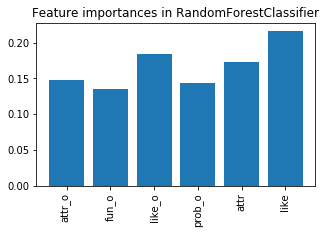

***IMPORTANT COLS:*** ['attr_o', 'fun_o', 'like_o', 'prob_o', 'attr', 'like']


In [26]:
rfc = ensemble.RandomForestClassifier(n_estimators=5000, random_state=10)
fit_and_train(rfc)

plt.figure(figsize=(5,3))
important_cols = (rfc.feature_importances_ > 0.05)
plt.bar(X_train.columns[important_cols], height=rfc.feature_importances_[important_cols])
plt.xticks(rotation=90)
plt.title('Feature importances in RandomForestClassifier')
plt.show()

print('***IMPORTANT COLS:***', list(X_train.columns[important_cols]))

In [27]:
gbm = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=2, loss='deviance')
fit_and_train(gbm)

***TRAIN***
R² for train: 0.9066293183940243
predicted     0     1   All
actual                     
0          1497   117  1614
1           130  1467  1597
All        1627  1584  3211

Type I errors: 3.64%
Type II errors: 4.05%

Precision: 92.61%
Recall: 91.86%

***TEST***
R² for test: 0.869447663190421
predicted     0    1   All
actual                    
0          1970  171  2141
1           167  281   448
All        2137  452  2589

Type I errors: 6.6%
Type II errors: 6.45%

Precision: 62.17%
Recall: 62.72%

***WHOLE***
R² for whole: 0.8536114329857087
predicted     0    1   All
actual                    
0          3898  384  4282
1           374  522   896
All        4272  906  5178

Type I errors: 7.42%
Type II errors: 7.22%

Precision: 57.62%
Recall: 58.26%


In [28]:
svm = SVC(C=10, kernel='poly', coef0=0.1, random_state=10)
fit_and_train(svm)

***TRAIN***
R² for train: 0.5368814192343604
predicted     0    1   All
actual                    
0          1532   82  1614
1          1317  280  1597
All        2849  362  3211

Type I errors: 2.55%
Type II errors: 41.02%

Precision: 77.35%
Recall: 17.53%

***TEST***
R² for test: 0.8103514870606412
predicted     0    1   All
actual                    
0          2024  117  2141
1           374   74   448
All        2398  191  2589

Type I errors: 4.52%
Type II errors: 14.45%

Precision: 38.74%
Recall: 16.52%

***WHOLE***
R² for whole: 0.8074546156817304
predicted     0    1   All
actual                    
0          4029  253  4282
1           744  152   896
All        4773  405  5178

Type I errors: 4.89%
Type II errors: 14.37%

Precision: 37.53%
Recall: 16.96%


## PCA, vs. Manual Feature Selection

In [29]:
df = raw_data.copy()

train_df = df.loc[::2]
test_df = df.loc[1::2]

X = df.loc[:, df.columns != 'match']
Y = df['match']

X_train = train_df.loc[:, train_df.columns != 'match']
Y_train = train_df['match']

X_test = test_df.loc[:, test_df.columns != 'match']
Y_test = test_df['match']

sm = SMOTE(random_state=1, ratio = 1.0)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)

print(Counter(Y_train_res))

oversampled_X_train, oversampled_X_test, oversampled_Y_train, oversampled_Y_test = train_test_split(X_train_res, Y_train_res, test_size=0.25, random_state=1)

Counter({0: 2141, 1: 2141})


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


10 Components: [9.99974714e-01 2.52721867e-05 1.03020650e-08 3.20833588e-10
 2.71723369e-10 2.04329216e-10 1.58336720e-10 1.55071231e-10
 1.39233943e-10 1.34737578e-10]
      [1.79369802e+06 9.01729401e+03 1.82061016e+02 3.21288169e+01
 2.95677525e+01 2.56401200e+01 2.25707319e+01 2.23367733e+01
 2.11654439e+01 2.08208851e+01]
5 Components: [9.99974714e-01 2.52721867e-05 1.03020650e-08 3.20833587e-10
 2.71723356e-10]
      [1.79369802e+06 9.01729401e+03 1.82061016e+02 3.21288169e+01
 2.95677518e+01]
3 Components: [9.99974714e-01 2.52721867e-05 1.03020650e-08]
      [1.79369802e+06 9.01729401e+03 1.82061016e+02]
2 Components: [9.99974714e-01 2.52721867e-05]
      [1793698.01861443    9017.29400739]


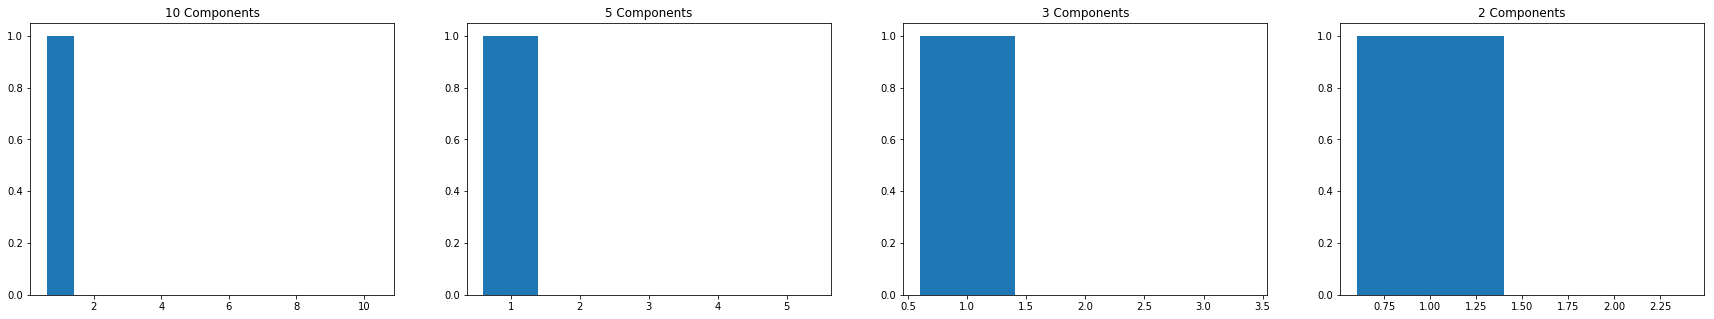

In [30]:
plt.figure(figsize=(30,5))

for idx, num_components in enumerate([10, 5, 3, 2]):
    pca = PCA(n_components=num_components)
    Y_sklearn = pca.fit_transform(oversampled_X_train)
    print(num_components, 'Components:', pca.explained_variance_ratio_)
    print('     ', pca.singular_values_)
    
    plt.subplot(1, 4, idx + 1)
    plt.bar(list(range(1, num_components + 1)), height=pca.explained_variance_ratio_)
    plt.title(str(num_components) + ' Components')
plt.show()

In [31]:
pca = PCA(n_components=1)
Y_sklearn = pca.fit_transform(oversampled_X_train)

pca_df = pd.DataFrame(data=Y_sklearn, columns=['feature_1'])
pca_df['match'] = oversampled_Y_train

rfc = ensemble.RandomForestClassifier(n_estimators=5000, random_state=10)
fit_and_train(rfc)

***TRAIN***
R² for train: 0.9355742296918768
predicted     0     1   All
actual                     
0          1614     0  1614
1             0  1597  1597
All        1614  1597  3211

Type I errors: 0.0%
Type II errors: 0.0%

Precision: 100.0%
Recall: 100.0%

***TEST***
R² for test: 0.9745075318655851
predicted     0    1   All
actual                    
0          2117   24  2141
1            42  406   448
All        2159  430  2589

Type I errors: 0.93%
Type II errors: 1.62%

Precision: 94.42%
Recall: 90.62%

***WHOLE***
R² for whole: 0.9148319814600232
predicted     0    1   All
actual                    
0          4138  144  4282
1           297  599   896
All        4435  743  5178

Type I errors: 2.78%
Type II errors: 5.74%

Precision: 80.62%
Recall: 66.85%


In [32]:
gbm = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=2, loss='deviance')
fit_and_train(gbm)

***TRAIN***
R² for train: 0.9197012138188608
predicted     0     1   All
actual                     
0          1594    20  1614
1            59  1538  1597
All        1653  1558  3211

Type I errors: 0.62%
Type II errors: 1.84%

Precision: 98.72%
Recall: 96.31%

***TEST***
R² for test: 0.936268829663963
predicted     0    1   All
actual                    
0          2081   60  2141
1           105  343   448
All        2186  403  2589

Type I errors: 2.32%
Type II errors: 4.06%

Precision: 85.11%
Recall: 76.56%

***WHOLE***
R² for whole: 0.8893395133256083
predicted     0    1   All
actual                    
0          4046  236  4282
1           337  559   896
All        4383  795  5178

Type I errors: 4.56%
Type II errors: 6.51%

Precision: 70.31%
Recall: 62.39%


In [ ]:
svm = SVC(C=10, kernel='poly', coef0=0.1, random_state=10)
fit_and_train(svm)

## Conclusion

My Random Forest Classifier model performed the best. When I manually selected features, it had an R² value of ~88% on the whole dataset, as well as a precision and recall rate of ~68%. Both Type I and Type II errors were below 6%. When I used PCA to  reduce dimensionality and the number of features (to 1 feature!), my Random Forest Classifier performed even better, with an R² of ~90%, precision rate of ~66%, and recall rate of ~78%. Both Type I and Type II errors were below 6.4%. 

The only downside is that the model may be slightly overfitted. With manually selected features, it had a train R² of ~88% and a test R² of ~95%, and then finally a whole dataset R² of ~84%. The PCA version of the model was less erratic – with R² values of 91%, 96%, and 90%, respectively – but it still was overfitting to a degree. I could adjust the model's hyperparameters to bring these 2 R² values closer together, but it would negatively impact the precision and recall rates. Depending on what I want to optimize for, I can easily tweak the hyperparameters to raise the value for different numbers.

## Deliverables

- 15 minute presentation that guides viewers through your model
- Specific research question your model addresses
- How you chose your model specification and what alternatives you compared it to
- The practical uses of your model for an audience of interest
- Any weak points or shortcomings of your model

In [ ]:
# notes
# parametric vs non-parametric models 
# lasso is parametric – there are conventions; features should be norm.distributed; no multicollinearity
# lasso – will help with multicollinearity

#    Over Sampling: 
# Create two parts of whole datasets (original dataset having both frauds and no frauds) - train and  test
#  Oversample the fraud part of train dataset to make it 50% each fraud and non fraud. Split this dataset in train and test - call them Over_Sampled_train, Over_Sampled_test
#  train your tree based model on Over_Sampled_train and test it on Over_Sampled_test. record precision and recall.
#  Not test the above trained model on test dataset create at the start of over sampling. Record recision and recall.